<h1 align="center" style="font-size: 30px">Optimal Locations to Build Additional Hospitals in New Jersey</h1>

<h3 align="center" style="margin-top: -5px">IBM Data Science Capstone Project</h3>

<h5 align="center" style="margin-top: -5px">By: Michael Manian</h5>

## Table of Contents

<hr>
<div class="alert alert-block alert-info" style="margin-top: 10px">
    Part 1. <a href="#item1">Gather data from sources and store it in DataFrames. </a><br>
    Part 2. <a href="#item2">Visualize the gathered data.</a><br>
    Part 3. <a href="#item3">Use FourSquare API to locate nearby hospitals.</a><br>
    Part 4. <a href="#item4">Cluster and visualize different combinations of the data.</a><br>
    Part 5. <a href="#item5">Analyze the clusters.</a><br>
</div>
<hr>

### <span style="background-color: #ADD8E6">1. Import required dependencies</span>

In [1]:
# Install packages
!pip install folium
!pip install geopy
!pip install xlrd
!pip install pandasql

from pandasql import sqldf # Library to use SQL commands on Pandas Dataframes

import pandas as pd # Library for data analsysis
import numpy as np # Library to handle data in a vectorized manner

# Make dataframes wider to display longer names
pd.options.display.max_colwidth = 1000

# Make dataframes display 3o total rows for previewing purposes
pd.options.display.max_rows = 30

from geopy.geocoders import Nominatim # Convert an address into latitude and longitude values
from geopy import distance # Find distance between two coordinates

import requests # Library to handle requests
import json # Library to handle JSON files
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

import folium # Map rendering library

# Matplotlib and associated plotting modules 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # For ggplot-like style
import matplotlib.cm as cm
import matplotlib.colors as colors

# Backend for rendering plots within the browser
%matplotlib inline

# Import k-means for clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

print('\nLibraries imported.')

     |████████████████████████████████| 102kB 5.8MB/s ta 0:00:011
  Stored in directory: /home/dsxuser/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql

Libraries imported.


<a name='item1'></a>
## Part 1: Gather data from sources and store it in DataFrames. 
<hr>

### <span style="background-color: #ADD8E6">2. Scrap New Jersey counties/municipalities data from Wikipedia</span>

In [2]:
# Scrap data from website and insert into a Pandas dataframe
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_municipalities_in_New_Jersey", header=0)[0]

# Print number of counties and municipalities
print('There are {} counties and {} municipalities in New Jersey.'.format(df['County'].nunique(), df.shape[0]))

# Group by county and add all municipalities per county separated by a semicolon in a new column
df = df.groupby('County')['Municipality'].apply('; '.join).reset_index()

# Add the word 'County' to every row under the County column to keep it consistent with other data sets
df['County'] = df['County'].astype(str) + ' County'

# Create new column counting the number of municipalities per county
df['Number of Municipalities'] = df['Municipality'].str.count(';').add(1)

# Display dataframe
df

There are 21 counties and 565 municipalities in New Jersey.


,County,Municipality,Number of Municipalities
0,Atlantic County,Egg Harbor Township; Atlantic City; Galloway Township; Hamilton Township; Pleasantville; Hammonton; Somers Point; Ventnor City; Brigantine; Northfield; Absecon; Buena Vista; Linwood; Margate City; Mullica Township; Buena; Egg Harbor City; Weymouth Township; Folsom; Estell Manor; Port Republic; Longport; Corbin City,23
1,Bergen County,Hackensack; Teaneck; Fort Lee; Fair Lawn; Garfield; Englewood; Bergenfield; Paramus; Mahwah; Ridgewood; Lodi; Cliffside Park; Lyndhurst; Palisades Park; Elmwood Park; Rutherford; Dumont; Wyckoff; New Milford; North Arlington; Tenafly; Ramsey; Fairview; Saddle Brook; Oakland; Ridgefield Park; Hasbrouck Heights; Glen Rock; Edgewater; River Edge; Wallington; Ridgefield; Westwood; Little Ferry; Franklin Lakes; Hillsdale; River Vale; Waldwick; Maywood; Washington Township; Leonia; East Rutherford; Park Ridge; Cresskill; Closter; Upper Saddle River; Bogota; Oradell; Montvale; Wood-Ridge; Emerson; Midland Park; Allendale; Carlstadt; Old Tappan; Woodcliff Lake; Norwood; Rochelle Park; Englewood Cliffs; Demarest; Harrington Park; Northvale; Ho-Ho-Kus; Haworth; Saddle River; Moonachie; South Hackensack; Alpine; Rockleigh; Teterboro,70
2,Burlington County,Evesham Township; Mount Laurel; Willingboro; Pemberton Township; Medford; Burlington Township; Moorestown; Maple Shade; Delran; Cinnaminson; Lumberton; Florence; Bordentown Township; Southampton; Burlington; Mount Holly; Edgewater Park; Westampton; Mansfield Township; Riverside; Chesterfield; North Hanover; Palmyra; New Hanover; Tabernacle; Shamong; Hainesport; Eastampton; Delanco; Medford Lakes; Bordentown; Springfield Township; Riverton; Beverly; Woodland Township; Bass River; Pemberton; Wrightstown; Washington Township; Fieldsboro,40
3,Camden County,Camden; Cherry Hill; Gloucester Township; Winslow Township; Pennsauken; Voorhees; Lindenwold; Haddon Township; Collingswood; Haddonfield; Bellmawr; Gloucester City; Waterford Township; Pine Hill; Audubon; Runnemede; Berlin; Haddon Heights; Stratford; Barrington; Berlin Township; Somerdale; Clementon; Mount Ephraim; Magnolia; Oaklyn; Merchantville; Woodlynne; Lawnside; Gibbsboro; Brooklawn; Laurel Springs; Chesilhurst; Audubon Park; Hi-Nella; Pine Valley; Tavistock,37
4,Cape May County,Lower Township; Middle Township; Upper Township; Ocean City; Dennis Township; Wildwood; North Wildwood; Cape May; Wildwood Crest; Woodbine; Sea Isle City; Avalon; West Cape May; Stone Harbor; West Wildwood; Cape May Point,16
5,Cumberland County,Vineland; Millville; Bridgeton; Maurice River; Upper Deerfield Township; Fairfield Township; Commercial Township; Hopewell Township; Lawrence Township; Deerfield Township; Downe Township; Stow Creek Township; Greenwich Township; Shiloh,14
6,Essex County,Newark; East Orange; Irvington; Bloomfield; West Orange; Montclair; Belleville; City of Orange; Livingston; Nutley; Maplewood; Millburn; South Orange Village; Verona; Cedar Grove; West Caldwell; Caldwell; Glen Ridge; Fairfield; North Caldwell; Roseland; Essex Fells,22
7,Gloucester County,Washington Township; Monroe Township; Deptford; West Deptford; Glassboro; Franklin Township; Mantua; Harrison Township; Woolwich Township; Woodbury; East Greenwich Township; Pitman; Clayton; Paulsboro; Logan Township; Greenwich Township; Westville; Elk Township; South Harrison Township; Woodbury Heights; National Park; Swedesboro; Wenonah; Newfield,24
8,Hudson County,Jersey City; Union City; Bayonne; North Bergen; Hoboken; West New York; Kearny; Secaucus; Harrison; Weehawken; Guttenberg; East Newark,12
9,Hunterdon County,Raritan Township; Readington; Clinton Township; Lebanon Township; Tewksbury; Union Township; Holland Township; Alexandria Township; Flemington; Delaware Township; East Amwell; Bethlehem Township; Lambertville; Kingwood Township; West Amwell; High Bridge; Franklin Township; Clinton; Glen Gardner; Hampton; Frenchtown; Lebanon; Milford; Califon; Bloomsbury; Stockton,26


### <span style="background-color: #ADD8E6">3. Scrap population data per County</span>

In [3]:
# Scrap population data from website and insert into a Pandas dataframe
df_pop = pd.read_html("https://www.newjersey-demographics.com/counties_by_population", header=0)[0]

# Drop unnecessary columns/rows
df_pop = df_pop.drop([21])
df_pop = df_pop.drop(columns=['Rank'])

# Rename column
df_pop = df_pop.rename(columns={'Population': 'Population (2020)'})

# Change population data type to integer
df_pop = df_pop.astype({'Population (2020)': int})

# Display Dataframe
df_pop

,County,Population (2020)
0,Bergen County,932202
1,Middlesex County,825062
2,Essex County,798975
3,Hudson County,672391
4,Monmouth County,618795
5,Ocean County,607186
6,Union County,556341
7,Camden County,506471
8,Passaic County,501826
9,Morris County,491845


### <span style="background-color: #ADD8E6">4. Scrap income data per County</span>

In [4]:
# Scrap income data from website and insert into a Pandas dataframe
df_income = pd.read_html("https://www.indexmundi.com/facts/united-states/quick-facts/new-jersey/median-household-income#table", header=0)[0]

# Add the word 'County' to every row under the County column to keep it consistent with other data sets
df_income['County'] = df_income['County'].astype(str) + ' County'

# Rename column name to accurately depict values
df_income.rename(columns={'Value': 'Median Income in $ (2018)'}, inplace=True)

# Display DataFrame
df_income

,County,Median Income in $ (2018)
0,Atlantic County,59989
1,Bergen County,95837
2,Burlington County,84992
3,Camden County,67118
4,Cape May County,63690
5,Cumberland County,52593
6,Essex County,59302
7,Gloucester County,85160
8,Hudson County,66289
9,Hunterdon County,112535


### <span style="background-color: #ADD8E6">5. Use Geopy library to get latitude and longitude values for each County</span>

In [5]:
# Empty list to store coordinates
coordinates=[]

# Loop through counties
for county in df['County']:
    try:
        address = county + ', New Jersey'
        geolocator = Nominatim(user_agent="nj_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude

        coordinates.append([(county, latitude, longitude)]) # Append coordinates into the list
    
    except AttributeError: # Incase Geopy cannot find coordinates for a specific location
        coordinates.append([(county, 'NF', 'NF')])
        print(county + "'s coordinates were not found.")


Middlesex County's coordinates were not found.
Monmouth County's coordinates were not found.


In [6]:
# Create dataframe storing the coordinates for each county
df_coordinates = pd.DataFrame([item for coordinates in coordinates for item in coordinates])

# Name the columns
df_coordinates.columns = ['County', 'Latitude', 'Longitude']

# Display DataFrame
df_coordinates

,County,Latitude,Longitude
0,Atlantic County,39.5143,-74.6633
1,Bergen County,40.9678,-74.0563
2,Burlington County,39.9325,-74.7227
3,Camden County,39.8015,-74.9686
4,Cape May County,39.1765,-74.8012
5,Cumberland County,39.3183,-75.1623
6,Essex County,40.7914,-74.2479
7,Gloucester County,39.7267,-75.1535
8,Hudson County,40.7382,-74.0551
9,Hunterdon County,40.5771,-74.9262


In [7]:
# Manually add the missing coordinates gathered from Google Maps
df_coordinates.at[11, 'Latitude'] = '40.4111'
df_coordinates.at[11, 'Longitude'] = '-74.3587'
df_coordinates.at[12, 'Latitude'] = '40.2589'
df_coordinates.at[12, 'Longitude'] = '-74.1240'

# Display DataFrame
df_coordinates

,County,Latitude,Longitude
0,Atlantic County,39.5143,-74.6633
1,Bergen County,40.9678,-74.0563
2,Burlington County,39.9325,-74.7227
3,Camden County,39.8015,-74.9686
4,Cape May County,39.1765,-74.8012
5,Cumberland County,39.3183,-75.1623
6,Essex County,40.7914,-74.2479
7,Gloucester County,39.7267,-75.1535
8,Hudson County,40.7382,-74.0551
9,Hunterdon County,40.5771,-74.9262


### <span style="background-color: #ADD8E6">6. Merge and sort all of the Dataframes into one</span>

In [8]:
# Merge dataframes
df_nj = pd.merge(df, df_coordinates, on='County')
df_nj = pd.merge(df_nj, df_pop, on='County')
df_nj = pd.merge(df_nj, df_income, on='County')

# Sort dataframe by county in alphabetical order
df_nj = df_nj.sort_values(['County']).reset_index(drop=True)

# Display DataFrame
df_nj

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018)
0,Atlantic County,Egg Harbor Township; Atlantic City; Galloway Township; Hamilton Township; Pleasantville; Hammonton; Somers Point; Ventnor City; Brigantine; Northfield; Absecon; Buena Vista; Linwood; Margate City; Mullica Township; Buena; Egg Harbor City; Weymouth Township; Folsom; Estell Manor; Port Republic; Longport; Corbin City,23,39.5143,-74.6633,263670,59989
1,Bergen County,Hackensack; Teaneck; Fort Lee; Fair Lawn; Garfield; Englewood; Bergenfield; Paramus; Mahwah; Ridgewood; Lodi; Cliffside Park; Lyndhurst; Palisades Park; Elmwood Park; Rutherford; Dumont; Wyckoff; New Milford; North Arlington; Tenafly; Ramsey; Fairview; Saddle Brook; Oakland; Ridgefield Park; Hasbrouck Heights; Glen Rock; Edgewater; River Edge; Wallington; Ridgefield; Westwood; Little Ferry; Franklin Lakes; Hillsdale; River Vale; Waldwick; Maywood; Washington Township; Leonia; East Rutherford; Park Ridge; Cresskill; Closter; Upper Saddle River; Bogota; Oradell; Montvale; Wood-Ridge; Emerson; Midland Park; Allendale; Carlstadt; Old Tappan; Woodcliff Lake; Norwood; Rochelle Park; Englewood Cliffs; Demarest; Harrington Park; Northvale; Ho-Ho-Kus; Haworth; Saddle River; Moonachie; South Hackensack; Alpine; Rockleigh; Teterboro,70,40.9678,-74.0563,932202,95837
2,Burlington County,Evesham Township; Mount Laurel; Willingboro; Pemberton Township; Medford; Burlington Township; Moorestown; Maple Shade; Delran; Cinnaminson; Lumberton; Florence; Bordentown Township; Southampton; Burlington; Mount Holly; Edgewater Park; Westampton; Mansfield Township; Riverside; Chesterfield; North Hanover; Palmyra; New Hanover; Tabernacle; Shamong; Hainesport; Eastampton; Delanco; Medford Lakes; Bordentown; Springfield Township; Riverton; Beverly; Woodland Township; Bass River; Pemberton; Wrightstown; Washington Township; Fieldsboro,40,39.9325,-74.7227,445349,84992
3,Camden County,Camden; Cherry Hill; Gloucester Township; Winslow Township; Pennsauken; Voorhees; Lindenwold; Haddon Township; Collingswood; Haddonfield; Bellmawr; Gloucester City; Waterford Township; Pine Hill; Audubon; Runnemede; Berlin; Haddon Heights; Stratford; Barrington; Berlin Township; Somerdale; Clementon; Mount Ephraim; Magnolia; Oaklyn; Merchantville; Woodlynne; Lawnside; Gibbsboro; Brooklawn; Laurel Springs; Chesilhurst; Audubon Park; Hi-Nella; Pine Valley; Tavistock,37,39.8015,-74.9686,506471,67118
4,Cape May County,Lower Township; Middle Township; Upper Township; Ocean City; Dennis Township; Wildwood; North Wildwood; Cape May; Wildwood Crest; Woodbine; Sea Isle City; Avalon; West Cape May; Stone Harbor; West Wildwood; Cape May Point,16,39.1765,-74.8012,92039,63690
5,Cumberland County,Vineland; Millville; Bridgeton; Maurice River; Upper Deerfield Township; Fairfield Township; Commercial Township; Hopewell Township; Lawrence Township; Deerfield Township; Downe Township; Stow Creek Township; Greenwich Township; Shiloh,14,39.3183,-75.1623,149527,52593
6,Essex County,Newark; East Orange; Irvington; Bloomfield; West Orange; Montclair; Belleville; City of Orange; Livingston; Nutley; Maplewood; Millburn; South Orange Village; Verona; Cedar Grove; West Caldwell; Caldwell; Glen Ridge; Fairfield; North Caldwell; Roseland; Essex Fells,22,40.7914,-74.2479,798975,59302
7,Gloucester County,Washington Township; Monroe Township; Deptford; West Deptford; Glassboro; Franklin Township; Mantua; Harrison Township; Woolwich Township; Woodbury; East Greenwich Township; Pitman; Clayton; Paulsboro; Logan Township; Greenwich Township; Westville; Elk Township; South Harrison Township; Woodbury Heights; National Park; Swedesboro; Wenonah; Newfield,24,39.7267,-75.1535,291636,85160
8,Hudson County,Jersey City; Union City; Bayonne; North Bergen; Hoboken; West New York; Kearny; Secaucus; Harrison; Weehawken; Guttenberg; East Newark,12,40.7382,-74.0551,672391,66289
9,Hunterdon County,Raritan Township; Readington; Clinton Township;

<a name='item2'></a>
## Part 2: Visualize the gathered data.
<hr>

### <span style="background-color: #ADD8E6">7. Display bar chart depicting population data</span>

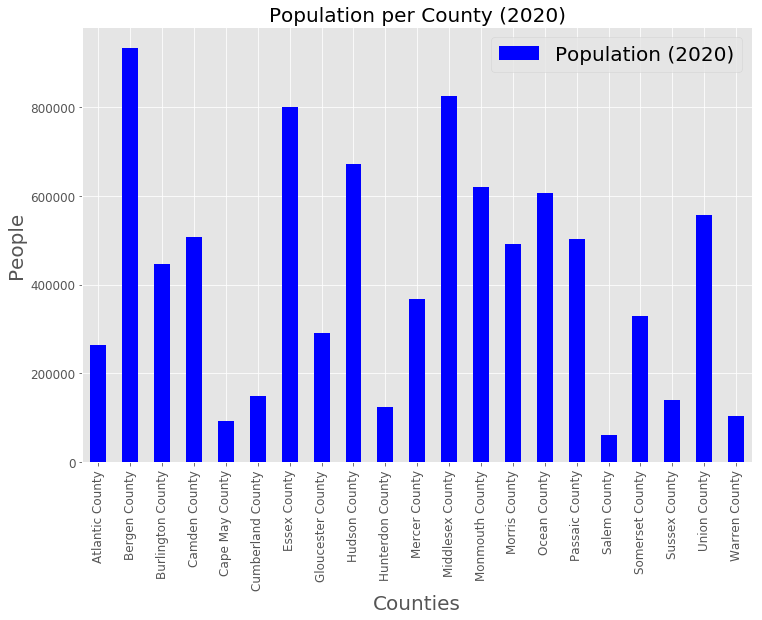

In [9]:
df_nj.plot(kind='bar', figsize=(12, 8), x='County', y='Population (2020)', color='blue', fontsize=12) # Plot data as a bar chart

plt.xlabel('Counties', fontsize=20) # Add to x-label to the plot
plt.ylabel('People', fontsize=20) # Add y-label to the plot
plt.title('Population per County (2020)', fontsize=20) # Add title to the plot
plt.legend(fontsize=20) # Adjust legend font

plt.show() # Show the bar chart

### <span style="background-color: #ADD8E6">8. Display bar chart depicting income data</span>

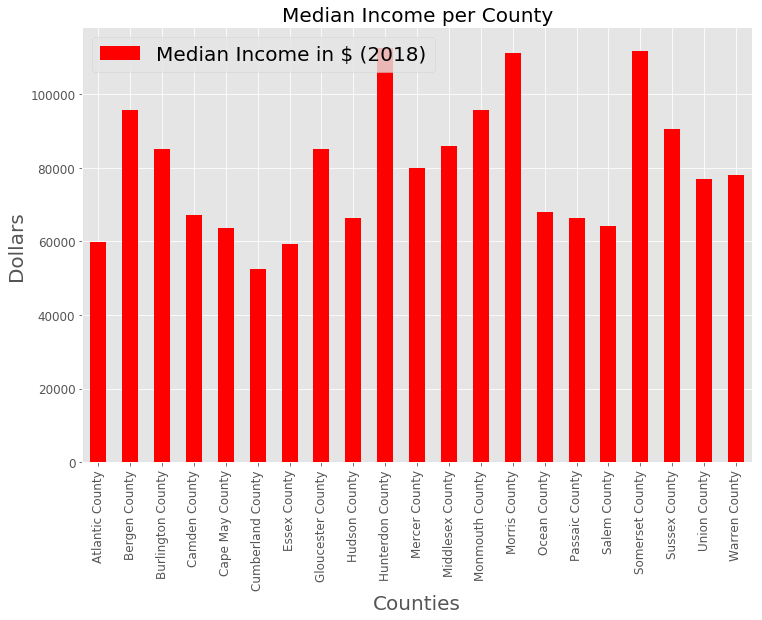

In [10]:
df_nj.plot(kind='bar', figsize=(12, 8), x='County', y='Median Income in $ (2018)', color='red', fontsize=12) # Plot data as a bar chart

plt.xlabel('Counties', fontsize=20) # Add to x-label to the plot
plt.ylabel('Dollars', fontsize=20) # Add y-label to the plot
plt.title('Median Income per County', fontsize=20) # Add title to the plot
plt.legend(fontsize=20) # Adjust legend font

plt.show() # Show the bar chart

### <span style="background-color: #ADD8E6">9. Display bar chart depicting municipality data</span>

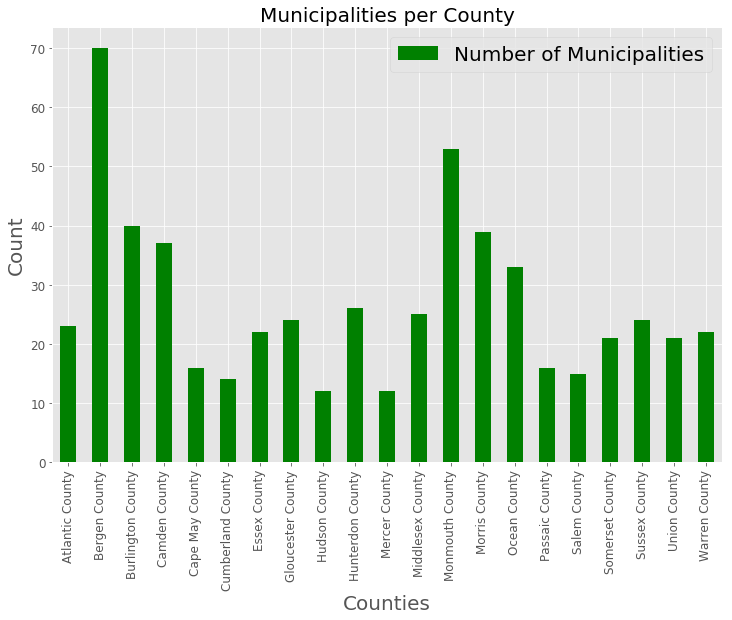

In [11]:
df_nj.plot(kind='bar', figsize=(12, 8), x='County', y='Number of Municipalities', color='green', fontsize=12) # Plot data as a bar chart

plt.xlabel('Counties', fontsize=20) # Add to x-label to the plot
plt.ylabel('Count', fontsize=20) # Add y-label to the plot
plt.title('Municipalities per County', fontsize=20) # Add title to the plot
plt.legend(fontsize=20) # Adjust legend font

plt.show() # Show the bar chart

### <span style="background-color: #ADD8E6">10. Create map of New Jersey with Counties superimposed on top</span>

In [12]:
# Get coordinates of New Jersey
address = 'New Jersey'
geolocator = Nominatim(user_agent="nj_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of New Jersey are {}, {}'.format(latitude, longitude))

The coordinates of New Jersey are 40.0757384, -74.4041622


In [13]:
# Create map of New Jersey using latitude and longitude values
map_nj = folium.Map(location=[latitude, longitude], zoom_start=8)

# Add markers to map
for lat, lng, county in zip(df_nj['Latitude'], df_nj['Longitude'], df_nj['County']):
    label = '{}'.format(county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_nj)  

# Display map
map_nj

<a name='item3'></a>
## Part 3: Use FourSquare API to locate nearby hospitals.
<hr>

### <span style="background-color: #ADD8E6">11. FourSquare API credentials</span>

In [14]:
# The code was removed by Watson Studio for sharing.

### <span style="background-color: #ADD8E6">12. Get nearby hospitals in each County using FourSquare API</span>

In [15]:
# Create definition to get nearby hospitals
def getNearbyHospitals(names, latitudes, longitudes, radius=100000, LIMIT=100):
    
    hospital_venues = [] # Create empty list to store hospitals
    HOSPITAL_ID = '4bf58dd8d48988d196941735' # Foursquare hospital category ID 
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            ACCESS_TOKEN, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            HOSPITAL_ID)
            
        # Make the GET request
        response = requests.get(url)

        # Print error message if no response
        if not response.status_code == 200:
            print("ERROR ", response.status_code, response.content)
            return None
        
        results = response.json()["response"]['groups'][0]['items']
        
        # Append only relevant information for each nearby hospital to the list
        hospital_venues.append([(
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['state']) for v in results])


    # Create dataframe from the list of hospitals created
    hospital_venues = pd.DataFrame([item for hospital_venues in hospital_venues for item in hospital_venues])
    hospital_venues.columns = ['Hospital Name', 
                              'Hospital Latitude', 
                              'Hospital Longitude',
                              'Hospital State']
    # Return dataframe
    return(hospital_venues)

In [16]:
# Call function definition to get nearby hospitals
df_hospitals = getNearbyHospitals(names=df_nj['County'],
                                   latitudes=df_nj['Latitude'],
                                   longitudes=df_nj['Longitude']
                                  )
# Display DataFrame
df_hospitals

,Hospital Name,Hospital Latitude,Hospital Longitude,Hospital State
0,Virtua Voorhees Hospital,39.842029,-74.927721,NJ
1,Kennedy University Hospital,39.735468,-75.065629,NJ
2,"AtlantiCare Regional Medical Center, Atlantic City Campus",39.358799,-74.434638,NJ
3,Shriner's Hospital for Children,40.007134,-75.151199,PA
4,VA Medical Center,39.949194,-75.199871,PA
5,Inspira Medical Center Vineland,39.444662,-75.058556,NJ
6,St. Christopher's Hospital for Children,40.006642,-75.124987,PA
7,Chestnut Hill Hospital,40.079143,-75.211689,PA
8,Penn Presbyterian Medical Center,39.958399,-75.199533,PA
9,Ocean Medical Center,40.077179,-74.132354,NJ


In [17]:
print('{} hospitals were returned by FourSquare.'.format(df_hospitals.shape[0]))

2100 hospitals were returned by FourSquare.


### <span style="background-color: #ADD8E6">13. Filter DataFrame to only display NJ hospitals</span>

In [18]:
# Check all the unique states in the DataFrame
df_hospitals['Hospital State'].unique()

array(['NJ', 'PA', 'DE', 'New Jersey', 'NY', 'CT', 'New York',
       'Pennsylvania', 'Delaware', 'MD'], dtype=object)

In [19]:
# Only display hospitals in New Jersey
df_hospitals = df_hospitals[(df_hospitals['Hospital State']  == 'New Jersey') | (df_hospitals['Hospital State']  == 'NJ')]

# Display DataFrame
df_hospitals

,Hospital Name,Hospital Latitude,Hospital Longitude,Hospital State
0,Virtua Voorhees Hospital,39.842029,-74.927721,NJ
1,Kennedy University Hospital,39.735468,-75.065629,NJ
2,"AtlantiCare Regional Medical Center, Atlantic City Campus",39.358799,-74.434638,NJ
5,Inspira Medical Center Vineland,39.444662,-75.058556,NJ
9,Ocean Medical Center,40.077179,-74.132354,NJ
10,Kimball Medical Center,40.073183,-74.219340,NJ
13,Virtua Memorial Hospital,39.986414,-74.795011,NJ
15,AtlantiCare Regional Medical Center - Imaging Services,39.358709,-74.434722,NJ
16,ARMCCity Hospital 3rd Fl Dialysis,39.358555,-74.434715,NJ
17,Acuity Speciality Hospital,39.358051,-74.434755,NJ


In [20]:
# Check if there are any duplicate hospital names
boolean = df_hospitals['Hospital Name'].duplicated().any()

# Prints either True or False
boolean

True

### <span style="background-color: #ADD8E6">14. Drop duplicate hospital names</span>

In [21]:
# Create new dataframe with only unique hospital names
unique_hospitals = df_hospitals.drop_duplicates(subset=['Hospital Name'], keep='first').reset_index(drop=True)

# Drop 'Hospital State' column since that is not needed anymore
unique_hospitals = unique_hospitals.drop(columns='Hospital State')

# Display DataFrame
unique_hospitals

,Hospital Name,Hospital Latitude,Hospital Longitude
0,Virtua Voorhees Hospital,39.842029,-74.927721
1,Kennedy University Hospital,39.735468,-75.065629
2,"AtlantiCare Regional Medical Center, Atlantic City Campus",39.358799,-74.434638
3,Inspira Medical Center Vineland,39.444662,-75.058556
4,Ocean Medical Center,40.077179,-74.132354
5,Kimball Medical Center,40.073183,-74.219340
6,Virtua Memorial Hospital,39.986414,-74.795011
7,AtlantiCare Regional Medical Center - Imaging Services,39.358709,-74.434722
8,ARMCCity Hospital 3rd Fl Dialysis,39.358555,-74.434715
9,Acuity Speciality Hospital,39.358051,-74.434755


### <span style="background-color: #ADD8E6">15. Perform CROSS JOIN (cartesian product) by using SQL commands</span>

In [22]:
# Using pandasql library
pysqldf = lambda q: sqldf(q, globals())

# SQL command for cross joining county coordinates and hospital coordinates dataframes
nj_hospitals = pysqldf('SELECT * FROM df_coordinates JOIN unique_hospitals')

# Display DataFrame
nj_hospitals

,County,Latitude,Longitude,Hospital Name,Hospital Latitude,Hospital Longitude
0,Atlantic County,39.5143268,-74.6632883,Virtua Voorhees Hospital,39.842029,-74.927721
1,Atlantic County,39.5143268,-74.6632883,Kennedy University Hospital,39.735468,-75.065629
2,Atlantic County,39.5143268,-74.6632883,"AtlantiCare Regional Medical Center, Atlantic City Campus",39.358799,-74.434638
3,Atlantic County,39.5143268,-74.6632883,Inspira Medical Center Vineland,39.444662,-75.058556
4,Atlantic County,39.5143268,-74.6632883,Ocean Medical Center,40.077179,-74.132354
5,Atlantic County,39.5143268,-74.6632883,Kimball Medical Center,40.073183,-74.219340
6,Atlantic County,39.5143268,-74.6632883,Virtua Memorial Hospital,39.986414,-74.795011
7,Atlantic County,39.5143268,-74.6632883,AtlantiCare Regional Medical Center - Imaging Services,39.358709,-74.434722
8,Atlantic County,39.5143268,-74.6632883,ARMCCity Hospital 3rd Fl Dialysis,39.358555,-74.434715
9,Atlantic County,39.5143268,-74.6632883,Acuity Speciality Hospital,39.358051,-74.434755


### <span style="background-color: #ADD8E6">16. Find distance between hospitals and counties to determine which hospital is in which county</span>

In [23]:
# Define function to calculate distance between two coordinates
def distance_calc(row):
    county_coords = (row['Latitude'], row['Longitude'])
    hospital_coords = (row['Hospital Latitude'], row['Hospital Longitude'])

    return distance.distance(county_coords, hospital_coords).km # Uses geopy's distance function

In [24]:
# Create new column to store distance and calculates distance for every row
nj_hospitals['Distance'] = nj_hospitals.apply (lambda row: distance_calc(row), axis=1)

# Display DataFrame
nj_hospitals

,County,Latitude,Longitude,Hospital Name,Hospital Latitude,Hospital Longitude,Distance
0,Atlantic County,39.5143268,-74.6632883,Virtua Voorhees Hospital,39.842029,-74.927721,42.877628
1,Atlantic County,39.5143268,-74.6632883,Kennedy University Hospital,39.735468,-75.065629,42.381177
2,Atlantic County,39.5143268,-74.6632883,"AtlantiCare Regional Medical Center, Atlantic City Campus",39.358799,-74.434638,26.185006
3,Atlantic County,39.5143268,-74.6632883,Inspira Medical Center Vineland,39.444662,-75.058556,34.876696
4,Atlantic County,39.5143268,-74.6632883,Ocean Medical Center,40.077179,-74.132354,77.286755
5,Atlantic County,39.5143268,-74.6632883,Kimball Medical Center,40.073183,-74.219340,72.773841
6,Atlantic County,39.5143268,-74.6632883,Virtua Memorial Hospital,39.986414,-74.795011,53.617657
7,Atlantic County,39.5143268,-74.6632883,AtlantiCare Regional Medical Center - Imaging Services,39.358709,-74.434722,26.186091
8,Atlantic County,39.5143268,-74.6632883,ARMCCity Hospital 3rd Fl Dialysis,39.358555,-74.434715,26.197872
9,Atlantic County,39.5143268,-74.6632883,Acuity Speciality Hospital,39.358051,-74.434755,26.232323


### <span style="background-color: #ADD8E6">17. Find shortest distance between Hospital and County to determine which County it resides in</span>

In [25]:
# Sort values by distance and only keep the county with the shortest distance to the hospital
nj_hospitals = nj_hospitals.sort_values('Distance', ascending=True).drop_duplicates('Hospital Name').sort_index().reset_index(drop=True)

# Display DataFrame
nj_hospitals

,County,Latitude,Longitude,Hospital Name,Hospital Latitude,Hospital Longitude,Distance
0,Atlantic County,39.5143268,-74.6632883,"AtlantiCare Regional Medical Center, Atlantic City Campus",39.358799,-74.434638,26.185006
1,Atlantic County,39.5143268,-74.6632883,AtlantiCare Regional Medical Center - Imaging Services,39.358709,-74.434722,26.186091
2,Atlantic County,39.5143268,-74.6632883,ARMCCity Hospital 3rd Fl Dialysis,39.358555,-74.434715,26.197872
3,Atlantic County,39.5143268,-74.6632883,Acuity Speciality Hospital,39.358051,-74.434755,26.232323
4,Atlantic County,39.5143268,-74.6632883,Shore Medical Center,39.314568,-74.592859,22.992310
5,Atlantic County,39.5143268,-74.6632883,ARMC PCCU,39.462763,-74.670688,5.760152
6,Bergen County,40.9678345,-74.0563254,Hackensack University Medical Center,40.884080,-74.056677,9.301200
7,Bergen County,40.9678345,-74.0563254,Holy Name Medical Center,40.883524,-74.010959,10.112641
8,Bergen County,40.9678345,-74.0563254,EHMC - Englewood Hospital and Medical Center,40.904010,-73.968415,10.249411
9,Bergen County,40.9678345,-74.0563254,The Valley Hospital,40.983591,-74.100692,4.123806


In [26]:
print('There are {} hospitals located in New Jersey returned by Foursquare.'.format(nj_hospitals.shape[0]))

There are 144 hospitals located in New Jersey returned by Foursquare.


In [27]:
# Double check if there are any duplicate hospital names
boolean = nj_hospitals['Hospital Name'].duplicated().any()

# Prints True or False (should be False now)
boolean

False

### <span style="background-color: #ADD8E6">18. Display bar chart depicting hospital data</span>

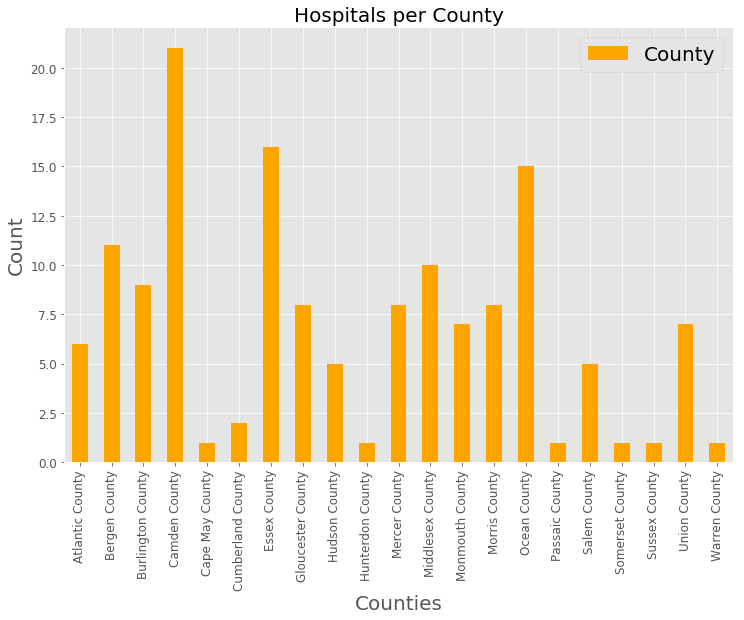

In [28]:
nj_hospitals['County'].value_counts().sort_index().plot(kind='bar', figsize=(12, 8), color='orange', fontsize=12) # Plot data as a bar chart

plt.xlabel('Counties', fontsize=20) # Add to x-label to the plot
plt.ylabel('Count', fontsize=20) # Add y-label to the plot
plt.title('Hospitals per County', fontsize=20) # Add title to the plot
plt.legend(fontsize=20) # Adjust legend font

plt.show() # Show the bar chart

### <span style="background-color: #ADD8E6">19. Create DataFrame displaying number of hospitals per County and merge with final DataFrame</span>

In [29]:
# Group by county and add all hospitals per county separated by a semicolon in a new column
hospitals = nj_hospitals.groupby('County')['Hospital Name'].apply('; '.join).reset_index()

# Create new column counting the number of hospitals per county
hospitals['Number of Hospitals'] = hospitals['Hospital Name'].str.count(';').add(1)

# Display DataFrame
hospitals

,County,Hospital Name,Number of Hospitals
0,Atlantic County,"AtlantiCare Regional Medical Center, Atlantic City Campus; AtlantiCare Regional Medical Center - Imaging Services; ARMCCity Hospital 3rd Fl Dialysis; Acuity Speciality Hospital; Shore Medical Center; ARMC PCCU",6
1,Bergen County,Hackensack University Medical Center; Holy Name Medical Center; EHMC - Englewood Hospital and Medical Center; The Valley Hospital; Hackensack Meridian Health Pascack Valley Medical Center; St. Joseph's Regional Medical Center; Bergen Regional Medical Center; Joseph M. Sanzari Children's Hospital; John Theurer Cancer Center; Holy Name Terrace Cafe; CityMD Teterboro,11
2,Burlington County,Virtua Memorial Hospital; Deborah Heart and Lung Center; Virtua Memorial 5 Stokes; Acquity Specialty Hospital; Lourdes Medical Center Of Burlington County; Lourdes Medical Center of Burlington County; Virtua Memorial Emergency Dept; CareOne Harmony Village; Samaritan Hospice @ Virtua Memorial Hospital,9
3,Camden County,"Virtua Voorhees Hospital; Virtua Berlin Hospital; Cooper University Hospital; Virtua Hospital(labor + Delivery - OR # 1; Virtua Voorhees CHOP Speciality Care Center; Jefferson Stratford Hospital; Cooper Surgical Associates; Virtua Marlton Hospital; Garden State OB/GYN - Voorhees; Camden County Health Services Center; elmwood hills healthcare center; Millennium Surgical Center; Virtua Health & Wellness Center - Voorhees; MedExpress Urgent Care; Jefferson Cherry Hill Hospital; Jefferson University Hospitals - Voorhees; Our Lady of Lourdes Hospital; Lourdes At Cherry Hill; Marlton Rehabilitation Hospital; cooper medical center 8th floor solarium; 1 Cooper Plaza, Camden, NJ",21
4,Cape May County,Cape Regional Medical Center,1
5,Cumberland County,Inspira Medical Center Vineland; Cumberland Manor,2
6,Essex County,Saint Barnabas Medical Center; Mountainside Hospital; Kessler Institute for Rehabilitation; Clara Maass Medical Center; Barnabas Health Ambulatory Care Center; Arlington Dog And Cat Hospital; VA Medical Center - East Orange; Veterans Hospital; East Orange General Hospital; SBMC - Radiation Oncology; The Cooperman Family Pavilion West Oncology; Clara Maass Icu Unit; University Hospital; St. Michael's Medical Center; St. Mary’s General Hospital; Immedicenter,16
7,Gloucester County,"Kennedy University Hospital; Virtua Medicine; Kennedy ER Washington Twp; Jefferson Washington Township Hospital; kennedy Surgical Center; Virtua Center for Surgery - Washington Township; Inspira Medical Center Woodbury; Joan Wiley, DO",8
8,Hudson County,Meadowlands Hospital Medical Center; CarePoint Health: Hoboken University Medical Center; Hackensack Meridian Health Palisades Medical Center; CarePoint Health: Bayonne Medical Center; Jersey City Medical Center,5
9,Hunterdon County,Hunterdon Medical Center,1


In [30]:
# Merge dataframes
df_nj = pd.merge(df_nj, hospitals, on='County')

# Display DataFrame
df_nj

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals
0,Atlantic County,Egg Harbor Township; Atlantic City; Galloway Township; Hamilton Township; Pleasantville; Hammonton; Somers Point; Ventnor City; Brigantine; Northfield; Absecon; Buena Vista; Linwood; Margate City; Mullica Township; Buena; Egg Harbor City; Weymouth Township; Folsom; Estell Manor; Port Republic; Longport; Corbin City,23,39.5143,-74.6633,263670,59989,"AtlantiCare Regional Medical Center, Atlantic City Campus; AtlantiCare Regional Medical Center - Imaging Services; ARMCCity Hospital 3rd Fl Dialysis; Acuity Speciality Hospital; Shore Medical Center; ARMC PCCU",6
1,Bergen County,Hackensack; Teaneck; Fort Lee; Fair Lawn; Garfield; Englewood; Bergenfield; Paramus; Mahwah; Ridgewood; Lodi; Cliffside Park; Lyndhurst; Palisades Park; Elmwood Park; Rutherford; Dumont; Wyckoff; New Milford; North Arlington; Tenafly; Ramsey; Fairview; Saddle Brook; Oakland; Ridgefield Park; Hasbrouck Heights; Glen Rock; Edgewater; River Edge; Wallington; Ridgefield; Westwood; Little Ferry; Franklin Lakes; Hillsdale; River Vale; Waldwick; Maywood; Washington Township; Leonia; East Rutherford; Park Ridge; Cresskill; Closter; Upper Saddle River; Bogota; Oradell; Montvale; Wood-Ridge; Emerson; Midland Park; Allendale; Carlstadt; Old Tappan; Woodcliff Lake; Norwood; Rochelle Park; Englewood Cliffs; Demarest; Harrington Park; Northvale; Ho-Ho-Kus; Haworth; Saddle River; Moonachie; South Hackensack; Alpine; Rockleigh; Teterboro,70,40.9678,-74.0563,932202,95837,Hackensack University Medical Center; Holy Name Medical Center; EHMC - Englewood Hospital and Medical Center; The Valley Hospital; Hackensack Meridian Health Pascack Valley Medical Center; St. Joseph's Regional Medical Center; Bergen Regional Medical Center; Joseph M. Sanzari Children's Hospital; John Theurer Cancer Center; Holy Name Terrace Cafe; CityMD Teterboro,11
2,Burlington County,Evesham Township; Mount Laurel; Willingboro; Pemberton Township; Medford; Burlington Township; Moorestown; Maple Shade; Delran; Cinnaminson; Lumberton; Florence; Bordentown Township; Southampton; Burlington; Mount Holly; Edgewater Park; Westampton; Mansfield Township; Riverside; Chesterfield; North Hanover; Palmyra; New Hanover; Tabernacle; Shamong; Hainesport; Eastampton; Delanco; Medford Lakes; Bordentown; Springfield Township; Riverton; Beverly; Woodland Township; Bass River; Pemberton; Wrightstown; Washington Township; Fieldsboro,40,39.9325,-74.7227,445349,84992,Virtua Memorial Hospital; Deborah Heart and Lung Center; Virtua Memorial 5 Stokes; Acquity Specialty Hospital; Lourdes Medical Center Of Burlington County; Lourdes Medical Center of Burlington County; Virtua Memorial Emergency Dept; CareOne Harmony Village; Samaritan Hospice @ Virtua Memorial Hospital,9
3,Camden County,Camden; Cherry Hill; Gloucester Township; Winslow Township; Pennsauken; Voorhees; Lindenwold; Haddon Township; Collingswood; Haddonfield; Bellmawr; Gloucester City; Waterford Township; Pine Hill; Audubon; Runnemede; Berlin; Haddon Heights; Stratford; Barrington; Berlin Township; Somerdale; Clementon; Mount Ephraim; Magnolia; Oaklyn; Merchantville; Woodlynne; Lawnside; Gibbsboro; Brooklawn; Laurel Springs; Chesilhurst; Audubon Park; Hi-Nella; Pine Valley; Tavistock,37,39.8015,-74.9686,506471,67118,"Virtua Voorhees Hospital; Virtua Berlin Hospital; Cooper University Hospital; Virtua Hospital(labor + Delivery - OR # 1; Virtua Voorhees CHOP Speciality Care Center; Jefferson Stratford Hospital; Cooper Surgical Associates; Virtua Marlton Hospital; Garden State OB/GYN - Voorhees; Camden County Health Services Center; elmwood hills healthcare center; Millennium Surgical Center; Virtua Health & Wellness Center - Voorhees; MedExpress Urgent Care; Jefferson Cherry Hill Hospital; Jefferson University Hospitals - Voorhees; Our Lady of Lourdes Hospital; Lourdes At Cherry Hill; Marlton Rehabilitation Hospi

In [31]:
df_nj.dtypes

County                       object
Municipality                 object
Number of Municipalities      int64
Latitude                     object
Longitude                    object
Population (2020)             int64
Median Income in $ (2018)     int64
Hospital Name                object
Number of Hospitals           int64
dtype: object

### <span style="background-color: #ADD8E6">19. Create map of New Jersey with Hospitals superimposed on top</span>

In [32]:
# Create map of New Jersey using latitude and longitude values
map_nj_hospitals = folium.Map(location=[latitude, longitude], zoom_start=8)

# Add markers to map
for lat, lng, name in zip(nj_hospitals['Hospital Latitude'], nj_hospitals['Hospital Longitude'], nj_hospitals['Hospital Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_nj_hospitals)  

# Display map
map_nj_hospitals

<a name='item4'></a>
## Part 4: Cluster and visualize different combinations of the data.
<hr>

### <span style="background-color: #ADD8E6">20. Scatter Plots to show correlation between different combinations</span>

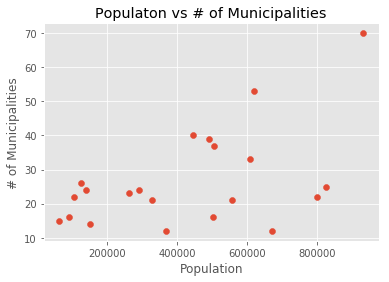

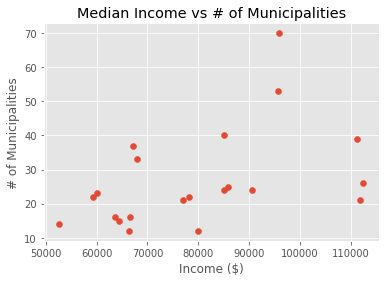

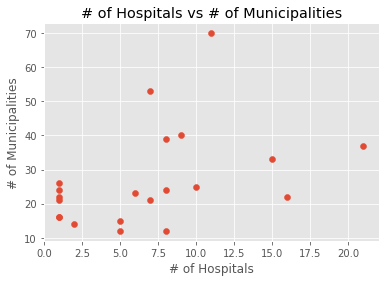

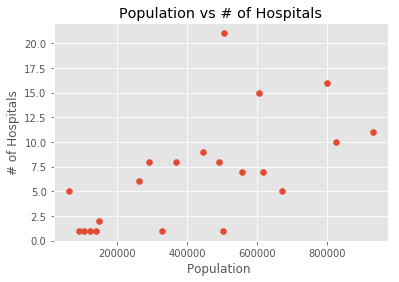

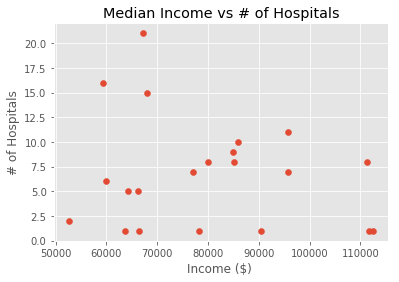

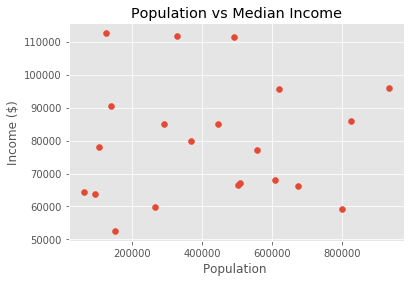

In [33]:
# Population vs # of Municipalities
plt.scatter(df_nj['Population (2020)'], df_nj['Number of Municipalities'])
plt.gca().update(dict(title='Populaton vs # of Municipalities', xlabel='Population', ylabel='# of Municipalities'))
plt.show()

# Median Income vs # of Municipalities
plt.scatter(df_nj['Median Income in $ (2018)'], df_nj['Number of Municipalities'])
plt.gca().update(dict(title='Median Income vs # of Municipalities', xlabel='Income ($)', ylabel='# of Municipalities'))
plt.show()

# # of Hospitals vs # of Municipalities
plt.scatter(df_nj['Number of Hospitals'], df_nj['Number of Municipalities'])
plt.gca().update(dict(title='# of Hospitals vs # of Municipalities', xlabel='# of Hospitals', ylabel='# of Municipalities'))
plt.show()

# Population vs # of Hospitals
plt.scatter(df_nj['Population (2020)'], df_nj['Number of Hospitals'])
plt.gca().update(dict(title='Population vs # of Hospitals', xlabel='Population ', ylabel='# of Hospitals'))
plt.show()

# Median Income vs # of Hospitals
plt.scatter(df_nj['Median Income in $ (2018)'], df_nj['Number of Hospitals'])
plt.gca().update(dict(title='Median Income vs # of Hospitals', xlabel='Income ($) ', ylabel='# of Hospitals'))
plt.show()

# Population vs Median Income
plt.scatter(df_nj['Population (2020)'], df_nj['Median Income in $ (2018)'])
plt.gca().update(dict(title='Population vs Median Income', xlabel='Population ', ylabel='Income ($)'))
plt.show()

### <span style="background-color: #ADD8E6">21. Prepare data for clustering</span>

In [34]:
# Cleaning data for k-means
df_clusters = df_nj.drop(columns=['County', 'Municipality', 'Latitude', 'Longitude', 'Hospital Name'])

# Display DataFrame
df_clusters

,Number of Municipalities,Population (2020),Median Income in $ (2018),Number of Hospitals
0,23,263670,59989,6
1,70,932202,95837,11
2,40,445349,84992,9
3,37,506471,67118,21
4,16,92039,63690,1
5,14,149527,52593,2
6,22,798975,59302,16
7,24,291636,85160,8
8,12,672391,66289,5
9,26,124371,112535,1


In [35]:
# Normalize data
normalized = preprocessing.StandardScaler().fit_transform(df_clusters)

# Create dataframe with normalized data
df_clusters_normalized = pd.DataFrame(normalized, index=df_clusters.index, columns=df_clusters.columns)

# Display DataFrame
df_clusters_normalized

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Number of Municipalities,Population (2020),Median Income in $ (2018),Number of Hospitals
0,-0.278108,-0.623232,-1.126382,-0.157423
1,3.069367,1.992416,0.906909,0.760878
2,0.932680,0.087592,0.291783,0.393558
3,0.719012,0.326733,-0.722026,2.597480
4,-0.776668,-1.294742,-0.916462,-1.075724
5,-0.919114,-1.069819,-1.545881,-0.892064
6,-0.349331,1.471162,-1.165348,1.679179
7,-0.206885,-0.513814,0.301312,0.209897
8,-1.061560,0.975899,-0.769047,-0.341083
9,-0.064440,-1.168243,1.854015,-1.075724


### <span style="background-color: #ADD8E6">22. Perform K-means clustering on Population vs # of Municipalities</span>

Text(0, 0.5, 'Silhouette Score')

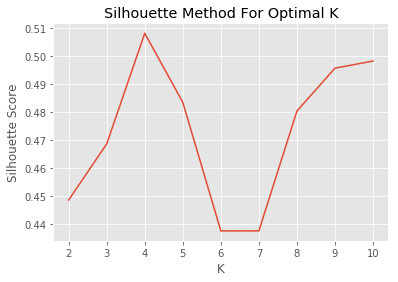

In [36]:
# Finding best k value for clustering by using the silhouette score method
score = []

# Dissimilarity would not be defined for a single cluster, so minimum number of clusters should be 2
for k in range(2, 11):
    km = KMeans(n_clusters=k).fit(df_clusters_normalized[['Population (2020)', 'Number of Municipalities']])
    labels = km.labels_
    score.append(silhouette_score(df_clusters_normalized[['Population (2020)', 'Number of Municipalities']], labels, metric='euclidean'))

# Show graph
plt.plot(range(2, 11), score)
plt.title('Silhouette Method For Optimal K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

In [37]:
# Finding which cluster each point belongs to
# 4 clusters are optimal according to the silhouette method
km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(df_clusters_normalized[['Population (2020)', 'Number of Municipalities']])

# Add new column to dataframe appending cluster values
df_nj['Cluster Pair 1'] = y_predicted

# Print cluster values
y_predicted

array([0, 2, 1, 1, 0, 0, 3, 0, 3, 0, 0, 3, 1, 1, 1, 3, 0, 0, 0, 3, 0],
      dtype=int32)

In [38]:
# Print out cluster centers
km.cluster_centers_

array([[-0.90139383, -0.51314382],
       [ 0.43416418,  0.96116958],
       [ 1.99241645,  3.06936652],
       [ 0.97014019, -0.54875525]])

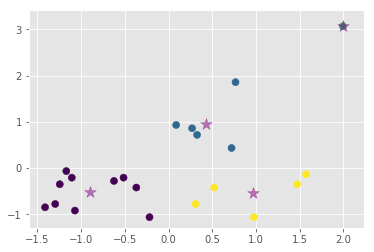

In [39]:
# Plot each cluster and its center
plt.scatter(normalized[:, 1], normalized[:, 0], c=y_predicted, s=50, cmap='viridis')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color='purple', s=150, alpha=0.5, marker='*')
plt.show()

### <span style="background-color: #ADD8E6">23. Perform K-means clustering on Median Income vs # of Municipalities</span>

Text(0, 0.5, 'Silhouette Score')

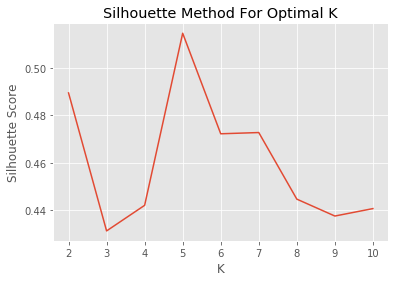

In [40]:
# Finding best k value for clustering by using the silhouette score method
score = []

# Dissimilarity would not be defined for a single cluster, so minimum number of clusters should be 2
for k in range(2, 11):
    km = KMeans(n_clusters=k).fit(df_clusters_normalized[['Median Income in $ (2018)', 'Number of Municipalities']])
    labels = km.labels_
    score.append(silhouette_score(df_clusters_normalized[['Median Income in $ (2018)', 'Number of Municipalities']], labels, metric='euclidean'))

# Show graph
plt.plot(range(2, 11), score)
plt.title('Silhouette Method For Optimal K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

In [41]:
# Finding which cluster each point belongs to
# 5 clusters are optimal according to the silhouette method
km = KMeans(n_clusters=5)
y_predicted = km.fit_predict(df_clusters_normalized[['Median Income in $ (2018)', 'Number of Municipalities']])

# Add new column to dataframe appending cluster values
df_nj['Cluster Pair 2'] = y_predicted

# Print cluster values
y_predicted

array([3, 1, 4, 4, 3, 3, 3, 0, 3, 2, 0, 0, 1, 2, 4, 3, 3, 2, 0, 0, 0],
      dtype=int32)

In [42]:
# Print out cluster centers
km.cluster_centers_

array([[ 0.16805796, -0.39681313],
       [ 0.90299487,  2.46397213],
       [ 1.81654232,  0.12548791],
       [-1.02327318, -0.71562026],
       [-0.3670174 ,  0.69527087]])

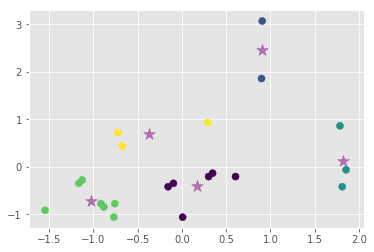

In [43]:
# Plot each cluster and its center
plt.scatter(normalized[:, 2], normalized[:, 0], c=y_predicted, s=50, cmap='viridis')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color='purple', s=150, alpha=0.5, marker='*')
plt.show()

### <span style="background-color: #ADD8E6">24. Perform K-means clustering on # of Hospitals vs # of Municipalities</span>

Text(0, 0.5, 'Silhouette Score')

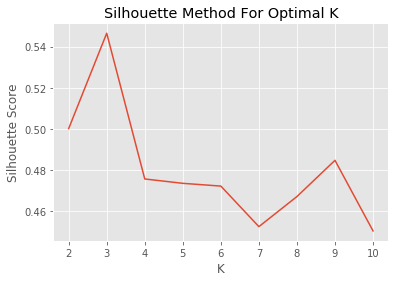

In [44]:
# Finding best k value for clustering by using the silhouette score method
score = []

# Dissimilarity would not be defined for a single cluster, so minimum number of clusters should be 2
for k in range(2, 11):
    km = KMeans(n_clusters=k).fit(df_clusters_normalized[['Number of Hospitals', 'Number of Municipalities']])
    labels = km.labels_
    score.append(silhouette_score(df_clusters_normalized[['Number of Hospitals', 'Number of Municipalities']], labels, metric='euclidean'))

# Show graph
plt.plot(range(2, 11), score)
plt.title('Silhouette Method For Optimal K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

In [45]:
# Finding which cluster each point belongs to
# 3 clusters are optimal according to the silhouette method
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df_clusters_normalized[['Number of Hospitals', 'Number of Municipalities']])

# Add new column to dataframe appending cluster values
df_nj['Cluster Pair 3'] = y_predicted

# Print cluster values
y_predicted

array([1, 0, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [46]:
# Print out cluster centers
km.cluster_centers_

array([[ 0.34764252,  1.68052057],
       [-0.51162484, -0.53756309],
       [ 1.92405924,  0.26793365]])

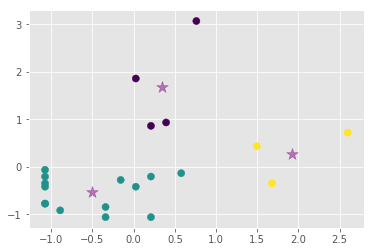

In [47]:
# Plot each cluster and its center
plt.scatter(normalized[:, 3], normalized[:, 0], c=y_predicted, s=50, cmap='viridis')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color='purple', s=150, alpha=0.5, marker='*')
plt.show()

### <span style="background-color: #ADD8E6">25. Perform K-means clustering on Population vs # of Hospitals</span>

Text(0, 0.5, 'Silhouette Score')

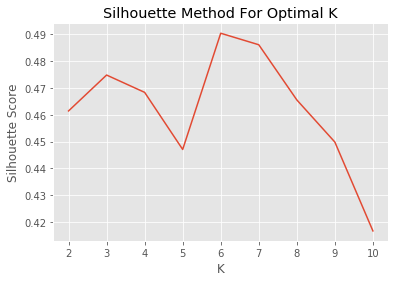

In [48]:
# Finding best k value for clustering by using the silhouette score method
score = []

# Dissimilarity would not be defined for a single cluster, so minimum number of clusters should be 2
for k in range(2, 11):
    km = KMeans(n_clusters=k).fit(df_clusters_normalized[['Population (2020)', 'Number of Hospitals']])
    labels = km.labels_
    score.append(silhouette_score(df_clusters_normalized[['Population (2020)', 'Number of Hospitals']], labels, metric='euclidean'))

# Show graph
plt.plot(range(2, 11), score)
plt.title('Silhouette Method For Optimal K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

In [49]:
# Finding which cluster each point belongs to
# 6 clusters are optimal according to the silhouette method
km = KMeans(n_clusters=6)
y_predicted = km.fit_predict(df_clusters_normalized[['Population (2020)', 'Number of Hospitals']])

# Add new column to dataframe appending cluster values
df_nj['Cluster Pair 4'] = y_predicted

# Print cluster values
y_predicted

array([0, 3, 0, 2, 1, 1, 2, 0, 5, 1, 0, 3, 5, 0, 2, 4, 1, 4, 1, 5, 1],
      dtype=int32)

In [50]:
# Print out cluster centers
km.cluster_centers_

array([[-0.19944264,  0.17316533],
       [-1.21528997, -0.92267387],
       [ 0.83955967,  1.92405924],
       [ 1.78282249,  0.66904787],
       [-0.02966253, -1.07572403],
       [ 0.75465136, -0.09620296]])

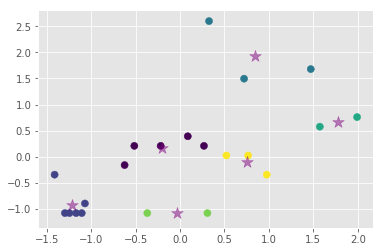

In [51]:
# Plot each cluster and its center
plt.scatter(normalized[:, 1], normalized[:, 3], c=y_predicted, s=50, cmap='viridis')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color='purple', s=150, alpha=0.5, marker='*')
plt.show()

### <span style="background-color: #ADD8E6">26. Perform K-means clustering on Median Income vs # of Hospitals</span>

Text(0, 0.5, 'Silhouette Score')

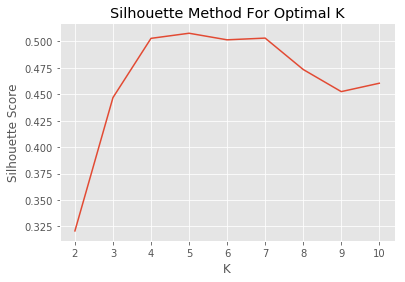

In [52]:
# Finding best k value for clustering by using the silhouette score method
score = []

# Dissimilarity would not be defined for a single cluster, so minimum number of clusters should be 2
for k in range(2, 11):
    km = KMeans(n_clusters=k).fit(df_clusters_normalized[['Median Income in $ (2018)', 'Number of Hospitals']])
    labels = km.labels_
    score.append(silhouette_score(df_clusters_normalized[['Median Income in $ (2018)', 'Number of Hospitals']], labels, metric='euclidean'))

# Show graph
plt.plot(range(2, 11), score)
plt.title('Silhouette Method For Optimal K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

In [53]:
# Finding which cluster each point belongs to
# 5 clusters are optimal according to the silhouette method
km = KMeans(n_clusters=5)
y_predicted = km.fit_predict(df_clusters_normalized[['Median Income in $ (2018)', 'Number of Hospitals']])

# Add new column to dataframe appending cluster values
df_nj['Cluster Pair 5'] = y_predicted

# Print cluster values
y_predicted

array([1, 3, 3, 2, 1, 1, 2, 3, 1, 4, 3, 3, 3, 4, 2, 1, 1, 4, 0, 3, 0],
      dtype=int32)

In [54]:
# Print out cluster centers
km.cluster_centers_

array([[ 0.25437599, -1.07572403],
       [-0.99959403, -0.64718356],
       [-0.85272765,  1.92405924],
       [ 0.3710526 ,  0.31484606],
       [ 1.81654232, -0.64718356]])

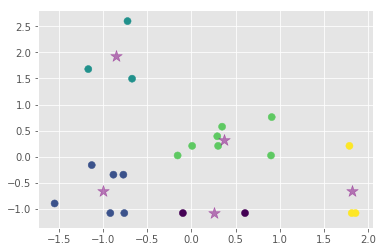

In [55]:
# Plot each cluster and its center
plt.scatter(normalized[:, 2], normalized[:, 3], c=y_predicted, s=50, cmap='viridis')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color='purple', s=150, alpha=0.5, marker='*')
plt.show()

### <span style="background-color: #ADD8E6">27. Perform K-means clustering on Population vs Median Income</span>

Text(0, 0.5, 'Silhouette Score')

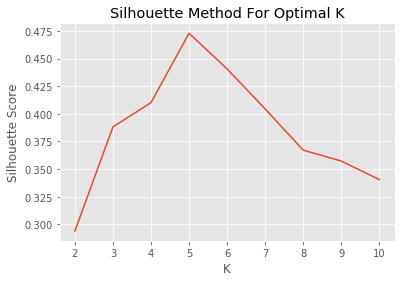

In [56]:
# Finding best k value for clustering by using the silhouette score method
score = []

# Dissimilarity would not be defined for a single cluster, so minimum number of clusters should be 2
for k in range(2, 11):
    km = KMeans(n_clusters=k).fit(df_clusters_normalized[['Population (2020)', 'Median Income in $ (2018)']])
    labels = km.labels_
    score.append(silhouette_score(df_clusters_normalized[['Population (2020)', 'Median Income in $ (2018)']], labels, metric='euclidean'))

# Show graph
plt.plot(range(2, 11), score)
plt.title('Silhouette Method For Optimal K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

In [57]:
# Finding which cluster each point belongs to
# 5 clusters are optimal according to the silhouette method
km = KMeans(n_clusters=5)
y_predicted = km.fit_predict(df_clusters_normalized[['Population (2020)', 'Median Income in $ (2018)']])

# Add new column to dataframe appending cluster values
df_nj['Cluster Pair 6'] = y_predicted

# Print cluster values
y_predicted

array([3, 2, 0, 1, 3, 3, 1, 0, 1, 4, 0, 2, 2, 4, 1, 1, 3, 4, 0, 1, 0],
      dtype=int32)

In [58]:
# Print out cluster centers
km.cluster_centers_

array([[-0.59833238,  0.22198334],
       [ 0.72083149, -0.70696731],
       [ 1.44394957,  0.71744561],
       [-1.09963932, -1.11751915],
       [-0.42220616,  1.81654232]])

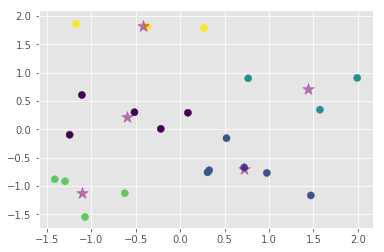

In [59]:
# Plot each cluster and its center
plt.scatter(normalized[:, 1], normalized[:, 2], c=y_predicted, s=50, cmap='viridis')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color='purple', s=150, alpha=0.5, marker='*')
plt.show()

<a name='item5'></a>
## Part 5: Analyze the clusters.
<hr>

### <span style="background-color: #ADD8E6">28. Check DataFrame for each cluster in Population vs # of Municipalities</span>

In [60]:
df_nj[(df_nj['Cluster Pair 1'] == 0)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
0,Atlantic County,Egg Harbor Township; Atlantic City; Galloway Township; Hamilton Township; Pleasantville; Hammonton; Somers Point; Ventnor City; Brigantine; Northfield; Absecon; Buena Vista; Linwood; Margate City; Mullica Township; Buena; Egg Harbor City; Weymouth Township; Folsom; Estell Manor; Port Republic; Longport; Corbin City,23,39.5143,-74.6633,263670,59989,"AtlantiCare Regional Medical Center, Atlantic City Campus; AtlantiCare Regional Medical Center - Imaging Services; ARMCCity Hospital 3rd Fl Dialysis; Acuity Speciality Hospital; Shore Medical Center; ARMC PCCU",6,0,3,1,0,1,3
4,Cape May County,Lower Township; Middle Township; Upper Township; Ocean City; Dennis Township; Wildwood; North Wildwood; Cape May; Wildwood Crest; Woodbine; Sea Isle City; Avalon; West Cape May; Stone Harbor; West Wildwood; Cape May Point,16,39.1765,-74.8012,92039,63690,Cape Regional Medical Center,1,0,3,1,1,1,3
5,Cumberland County,Vineland; Millville; Bridgeton; Maurice River; Upper Deerfield Township; Fairfield Township; Commercial Township; Hopewell Township; Lawrence Township; Deerfield Township; Downe Township; Stow Creek Township; Greenwich Township; Shiloh,14,39.3183,-75.1623,149527,52593,Inspira Medical Center Vineland; Cumberland Manor,2,0,3,1,1,1,3
7,Gloucester County,Washington Township; Monroe Township; Deptford; West Deptford; Glassboro; Franklin Township; Mantua; Harrison Township; Woolwich Township; Woodbury; East Greenwich Township; Pitman; Clayton; Paulsboro; Logan Township; Greenwich Township; Westville; Elk Township; South Harrison Township; Woodbury Heights; National Park; Swedesboro; Wenonah; Newfield,24,39.7267,-75.1535,291636,85160,"Kennedy University Hospital; Virtua Medicine; Kennedy ER Washington Twp; Jefferson Washington Township Hospital; kennedy Surgical Center; Virtua Center for Surgery - Washington Township; Inspira Medical Center Woodbury; Joan Wiley, DO",8,0,0,1,0,3,0
9,Hunterdon County,Raritan Township; Readington; Clinton Township; Lebanon Township; Tewksbury; Union Township; Holland Township; Alexandria Township; Flemington; Delaware Township; East Amwell; Bethlehem Township; Lambertville; Kingwood Township; West Amwell; High Bridge; Franklin Township; Clinton; Glen Gardner; Hampton; Frenchtown; Lebanon; Milford; Califon; Bloomsbury; Stockton,26,40.5771,-74.9262,124371,112535,Hunterdon Medical Center,1,0,2,1,1,4,4
10,Mercer County,Hamilton; Trenton; Ewing; Lawrence; Princeton; East Windsor; West Windsor; Hopewell Township; Robbinsville; Hightstown; Pennington; Hopewell,12,40.2807,-74.7034,367430,79990,"University Medical Center of Princeton at Plainsboro, Medical Arts Pavilion; University Medical Center of Princeton at Plainsboro; RWJ University Hospital Hamilton; NorthStar Vets; Robertwood Johnson University Hospital Hamilton: Tele North; Mercer Family Health Center; Capital Health Regional Medical Center; Capital Health Medical Center - Hopewell",8,0,0,1,0,3,0
16,Salem County,Pennsville; Pittsgrove Township; Carneys Point; Penns Grove; Salem; Pilesgrove Township; Upper Pittsgrove; Woodstown; Alloway Township; Quinton Township; Mannington Township; Oldmans Township; Lower Alloways Creek; Elmer; Elsinboro Township,15,39.5981,-75.3488,62385,64309,Elmer Hospital; Inspira Medical Center Elmer; Elmer Hospital-surgical waiting room; Memorial Hospital Salem County; Salem Medical Center,5,0,3,1,1,1,3
17,Somerset County,Franklin Township; Bridgewater; Hillsborough; Bernards Township; Montgomery; North Plainfield; Warren; Branchburg; Somerville; Bound Brook; Manville; Bedminster; Bernardsville; Green Brook; Raritan; Watchung; South Bound Brook; Peapack and Gladstone; Far Hills; Rocky Hill; Millstone,21,40.5675,-74.619,328934,111772,Carrier Clinic,1,0,2,1,4,4,4
18,Sussex County,Vernon; Spa

In [61]:
df_nj[(df_nj['Cluster Pair 1'] == 1)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
2,Burlington County,Evesham Township; Mount Laurel; Willingboro; Pemberton Township; Medford; Burlington Township; Moorestown; Maple Shade; Delran; Cinnaminson; Lumberton; Florence; Bordentown Township; Southampton; Burlington; Mount Holly; Edgewater Park; Westampton; Mansfield Township; Riverside; Chesterfield; North Hanover; Palmyra; New Hanover; Tabernacle; Shamong; Hainesport; Eastampton; Delanco; Medford Lakes; Bordentown; Springfield Township; Riverton; Beverly; Woodland Township; Bass River; Pemberton; Wrightstown; Washington Township; Fieldsboro,40,39.9325,-74.7227,445349,84992,Virtua Memorial Hospital; Deborah Heart and Lung Center; Virtua Memorial 5 Stokes; Acquity Specialty Hospital; Lourdes Medical Center Of Burlington County; Lourdes Medical Center of Burlington County; Virtua Memorial Emergency Dept; CareOne Harmony Village; Samaritan Hospice @ Virtua Memorial Hospital,9,1,4,0,0,3,0
3,Camden County,Camden; Cherry Hill; Gloucester Township; Winslow Township; Pennsauken; Voorhees; Lindenwold; Haddon Township; Collingswood; Haddonfield; Bellmawr; Gloucester City; Waterford Township; Pine Hill; Audubon; Runnemede; Berlin; Haddon Heights; Stratford; Barrington; Berlin Township; Somerdale; Clementon; Mount Ephraim; Magnolia; Oaklyn; Merchantville; Woodlynne; Lawnside; Gibbsboro; Brooklawn; Laurel Springs; Chesilhurst; Audubon Park; Hi-Nella; Pine Valley; Tavistock,37,39.8015,-74.9686,506471,67118,"Virtua Voorhees Hospital; Virtua Berlin Hospital; Cooper University Hospital; Virtua Hospital(labor + Delivery - OR # 1; Virtua Voorhees CHOP Speciality Care Center; Jefferson Stratford Hospital; Cooper Surgical Associates; Virtua Marlton Hospital; Garden State OB/GYN - Voorhees; Camden County Health Services Center; elmwood hills healthcare center; Millennium Surgical Center; Virtua Health & Wellness Center - Voorhees; MedExpress Urgent Care; Jefferson Cherry Hill Hospital; Jefferson University Hospitals - Voorhees; Our Lady of Lourdes Hospital; Lourdes At Cherry Hill; Marlton Rehabilitation Hospital; cooper medical center 8th floor solarium; 1 Cooper Plaza, Camden, NJ",21,1,4,2,2,2,1
12,Monmouth County,Middletown; Howell; Marlboro; Manalapan; Freehold Township; Long Branch; Neptune; Ocean Township; Wall Township; Hazlet; Aberdeen; Tinton Falls; Holmdel; Asbury Park; Eatontown; Red Bank; Freehold; Millstone Township; Colts Neck; Keansburg; Matawan; West Long Branch; Keyport; Rumson; Upper Freehold; Union Beach; Fair Haven; Little Silver; Manasquan; Oceanport; Belmar; Highlands; Neptune City; Brielle; Spring Lake Heights; Atlantic Highlands; Bradley Beach; Shrewsbury; Monmouth Beach; Spring Lake; Avon-by-the-Sea; Englishtown; Allentown; Sea Girt; Lake Como; Sea Bright; Farmingdale; Shrewsbury Township; Roosevelt; Interlaken; Deal; Allenhurst; Loch Arbour,53,40.2589,-74.1240,618795,95699,Ocean Medical Center; Jersey Shore University Medical Center; Monmouth Medical Center; Riverview Medical Center; CentraState Medical Center; Northwest Pavilion; Jersey Shore University Medical Center - Nuclear Medicine,7,1,1,0,5,3,2
13,Morris County,Parsippany; Mount Olive; Randolph; Rockaway Township; Roxbury; Morris Township; Montville; Jefferson Township; Washington Township; Morristown; Dover; Denville; Madison; Pequannock; Hanover; Florham Park; East Hanover; Lincoln Park; Chatham Township; Kinnelon; Chatham; Long Hill Township; Boonton; Chester Township; Butler; Wharton; Rockaway; Mendham Township; Morris Plains; Mount Arlington; Mendham; Boonton Township; Mountain Lakes; Harding Township; Mine Hill; Riverdale; Netcong; Chester Borough; Victory Gardens,39,40.868,-74.5601,491845,111316,Gagnon Cardiovascular Institute; Morristown Medical Center; Morristown Memorial Hospital; St. Clare's Hospital; Kessler Rehab 

In [62]:
df_nj[(df_nj['Cluster Pair 1'] == 2)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
1,Bergen County,Hackensack; Teaneck; Fort Lee; Fair Lawn; Garfield; Englewood; Bergenfield; Paramus; Mahwah; Ridgewood; Lodi; Cliffside Park; Lyndhurst; Palisades Park; Elmwood Park; Rutherford; Dumont; Wyckoff; New Milford; North Arlington; Tenafly; Ramsey; Fairview; Saddle Brook; Oakland; Ridgefield Park; Hasbrouck Heights; Glen Rock; Edgewater; River Edge; Wallington; Ridgefield; Westwood; Little Ferry; Franklin Lakes; Hillsdale; River Vale; Waldwick; Maywood; Washington Township; Leonia; East Rutherford; Park Ridge; Cresskill; Closter; Upper Saddle River; Bogota; Oradell; Montvale; Wood-Ridge; Emerson; Midland Park; Allendale; Carlstadt; Old Tappan; Woodcliff Lake; Norwood; Rochelle Park; Englewood Cliffs; Demarest; Harrington Park; Northvale; Ho-Ho-Kus; Haworth; Saddle River; Moonachie; South Hackensack; Alpine; Rockleigh; Teterboro,70,40.9678,-74.0563,932202,95837,Hackensack University Medical Center; Holy Name Medical Center; EHMC - Englewood Hospital and Medical Center; The Valley Hospital; Hackensack Meridian Health Pascack Valley Medical Center; St. Joseph's Regional Medical Center; Bergen Regional Medical Center; Joseph M. Sanzari Children's Hospital; John Theurer Cancer Center; Holy Name Terrace Cafe; CityMD Teterboro,11,2,1,0,3,3,2


In [63]:
df_nj[(df_nj['Cluster Pair 1'] == 3)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
6,Essex County,Newark; East Orange; Irvington; Bloomfield; West Orange; Montclair; Belleville; City of Orange; Livingston; Nutley; Maplewood; Millburn; South Orange Village; Verona; Cedar Grove; West Caldwell; Caldwell; Glen Ridge; Fairfield; North Caldwell; Roseland; Essex Fells,22,40.7914,-74.2479,798975,59302,Saint Barnabas Medical Center; Mountainside Hospital; Kessler Institute for Rehabilitation; Clara Maass Medical Center; Barnabas Health Ambulatory Care Center; Arlington Dog And Cat Hospital; VA Medical Center - East Orange; Veterans Hospital; East Orange General Hospital; SBMC - Radiation Oncology; The Cooperman Family Pavilion West Oncology; Clara Maass Icu Unit; University Hospital; St. Michael's Medical Center; St. Mary’s General Hospital; Immedicenter,16,3,3,2,2,2,1
8,Hudson County,Jersey City; Union City; Bayonne; North Bergen; Hoboken; West New York; Kearny; Secaucus; Harrison; Weehawken; Guttenberg; East Newark,12,40.7382,-74.0551,672391,66289,Meadowlands Hospital Medical Center; CarePoint Health: Hoboken University Medical Center; Hackensack Meridian Health Palisades Medical Center; CarePoint Health: Bayonne Medical Center; Jersey City Medical Center,5,3,3,1,5,1,1
11,Middlesex County,Edison; Woodbridge; Old Bridge; Piscataway; New Brunswick; Perth Amboy; East Brunswick; South Brunswick; Sayreville; North Brunswick; Monroe Township; South Plainfield; Plainsboro; Carteret; South River; Highland Park; Middlesex; Metuchen; South Amboy; Spotswood; Dunellen; Milltown; Jamesburg; Cranbury; Helmetta,25,40.4111,-74.3587,825062,85954,"Robert Wood Johnson University Hospital; Saint Peter's University Hospital; 6 North; Robert Wood Johnson University Hospital; Hackensack Meridian Health Raritan Bay Medical Center - Perth Amboy; Raritan Bay -Old Bridge; Bayshore Community Hospital; Northern Monmouth Regional Surgery Center, LLC; Mediplus Home Health; Raritan Bay Medical Center Cafeteria",10,3,0,1,3,3,2
15,Passaic County,Paterson; Clifton; Passaic; Wayne; West Milford; Hawthorne; Little Falls; Ringwood; Woodland Park; Wanaque; Pompton Lakes; Totowa; North Haledon; Haledon; Bloomingdale; Prospect Park,16,41.0462,-74.3178,501826,66476,Chilton Memorial Hospital,1,3,3,1,4,1,1
19,Union County,Elizabeth; Union; Plainfield; Linden; Westfield; Rahway; Scotch Plains; Cranford; Summit; Hillside; Roselle; Springfield; Clark; Roselle Park; Berkeley Heights; New Providence; Kenilworth; Fanwood; Mountainside; Garwood; Winfield,21,40.6652,-74.3045,556341,77095,Overlook Medical Center; Newark Beth Israel Medical Center; Trinitas Regional Medical Center; RWJ University Hospital Rahway; Runnells Specialized Hospital; Mercy 6; JFK Johnson Rehabilitation Institute,7,3,0,1,5,3,1


### <span style="background-color: #ADD8E6">29. Check DataFrame for each cluster in Median Income vs # of Municipalities</span>

In [64]:
df_nj[(df_nj['Cluster Pair 2'] == 0)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
7,Gloucester County,Washington Township; Monroe Township; Deptford; West Deptford; Glassboro; Franklin Township; Mantua; Harrison Township; Woolwich Township; Woodbury; East Greenwich Township; Pitman; Clayton; Paulsboro; Logan Township; Greenwich Township; Westville; Elk Township; South Harrison Township; Woodbury Heights; National Park; Swedesboro; Wenonah; Newfield,24,39.7267,-75.1535,291636,85160,"Kennedy University Hospital; Virtua Medicine; Kennedy ER Washington Twp; Jefferson Washington Township Hospital; kennedy Surgical Center; Virtua Center for Surgery - Washington Township; Inspira Medical Center Woodbury; Joan Wiley, DO",8,0,0,1,0,3,0
10,Mercer County,Hamilton; Trenton; Ewing; Lawrence; Princeton; East Windsor; West Windsor; Hopewell Township; Robbinsville; Hightstown; Pennington; Hopewell,12,40.2807,-74.7034,367430,79990,"University Medical Center of Princeton at Plainsboro, Medical Arts Pavilion; University Medical Center of Princeton at Plainsboro; RWJ University Hospital Hamilton; NorthStar Vets; Robertwood Johnson University Hospital Hamilton: Tele North; Mercer Family Health Center; Capital Health Regional Medical Center; Capital Health Medical Center - Hopewell",8,0,0,1,0,3,0
11,Middlesex County,Edison; Woodbridge; Old Bridge; Piscataway; New Brunswick; Perth Amboy; East Brunswick; South Brunswick; Sayreville; North Brunswick; Monroe Township; South Plainfield; Plainsboro; Carteret; South River; Highland Park; Middlesex; Metuchen; South Amboy; Spotswood; Dunellen; Milltown; Jamesburg; Cranbury; Helmetta,25,40.4111,-74.3587,825062,85954,"Robert Wood Johnson University Hospital; Saint Peter's University Hospital; 6 North; Robert Wood Johnson University Hospital; Hackensack Meridian Health Raritan Bay Medical Center - Perth Amboy; Raritan Bay -Old Bridge; Bayshore Community Hospital; Northern Monmouth Regional Surgery Center, LLC; Mediplus Home Health; Raritan Bay Medical Center Cafeteria",10,3,0,1,3,3,2
18,Sussex County,Vernon; Sparta; Hopatcong; Wantage Township; Byram Township; Hardyston Township; Newton; Andover Township; Frankford Township; Hampton Township; Franklin; Stillwater Township; Montague; Stanhope; Green Township; Fredon Township; Hamburg; Lafayette; Ogdensburg; Sussex; Sandyston Township; Branchville; Andover; Walpack Township,24,41.1334,-74.693,140488,90520,Newton Medical Center,1,0,0,1,1,0,0
19,Union County,Elizabeth; Union; Plainfield; Linden; Westfield; Rahway; Scotch Plains; Cranford; Summit; Hillside; Roselle; Springfield; Clark; Roselle Park; Berkeley Heights; New Providence; Kenilworth; Fanwood; Mountainside; Garwood; Winfield,21,40.6652,-74.3045,556341,77095,Overlook Medical Center; Newark Beth Israel Medical Center; Trinitas Regional Medical Center; RWJ University Hospital Rahway; Runnells Specialized Hospital; Mercy 6; JFK Johnson Rehabilitation Institute,7,3,0,1,5,3,1
20,Warren County,Phillipsburg; Hackettstown; Lopatcong Township; Mansfield Township; Washington Township; Washington; Blairstown; Greenwich Township; Independence Township; White Township; Allamuchy; Pohatcong Township; Franklin Township; Knowlton Township; Liberty Township; Belvidere; Harmony Township; Oxford Township; Alpha; Frelinghuysen Township; Hope Township; Hardwick Township,22,40.8602,-74.972,105267,78145,Hackettstown Regional Medical Center,1,0,0,1,1,0,0


In [65]:
df_nj[(df_nj['Cluster Pair 2'] == 1)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
1,Bergen County,Hackensack; Teaneck; Fort Lee; Fair Lawn; Garfield; Englewood; Bergenfield; Paramus; Mahwah; Ridgewood; Lodi; Cliffside Park; Lyndhurst; Palisades Park; Elmwood Park; Rutherford; Dumont; Wyckoff; New Milford; North Arlington; Tenafly; Ramsey; Fairview; Saddle Brook; Oakland; Ridgefield Park; Hasbrouck Heights; Glen Rock; Edgewater; River Edge; Wallington; Ridgefield; Westwood; Little Ferry; Franklin Lakes; Hillsdale; River Vale; Waldwick; Maywood; Washington Township; Leonia; East Rutherford; Park Ridge; Cresskill; Closter; Upper Saddle River; Bogota; Oradell; Montvale; Wood-Ridge; Emerson; Midland Park; Allendale; Carlstadt; Old Tappan; Woodcliff Lake; Norwood; Rochelle Park; Englewood Cliffs; Demarest; Harrington Park; Northvale; Ho-Ho-Kus; Haworth; Saddle River; Moonachie; South Hackensack; Alpine; Rockleigh; Teterboro,70,40.9678,-74.0563,932202,95837,Hackensack University Medical Center; Holy Name Medical Center; EHMC - Englewood Hospital and Medical Center; The Valley Hospital; Hackensack Meridian Health Pascack Valley Medical Center; St. Joseph's Regional Medical Center; Bergen Regional Medical Center; Joseph M. Sanzari Children's Hospital; John Theurer Cancer Center; Holy Name Terrace Cafe; CityMD Teterboro,11,2,1,0,3,3,2
12,Monmouth County,Middletown; Howell; Marlboro; Manalapan; Freehold Township; Long Branch; Neptune; Ocean Township; Wall Township; Hazlet; Aberdeen; Tinton Falls; Holmdel; Asbury Park; Eatontown; Red Bank; Freehold; Millstone Township; Colts Neck; Keansburg; Matawan; West Long Branch; Keyport; Rumson; Upper Freehold; Union Beach; Fair Haven; Little Silver; Manasquan; Oceanport; Belmar; Highlands; Neptune City; Brielle; Spring Lake Heights; Atlantic Highlands; Bradley Beach; Shrewsbury; Monmouth Beach; Spring Lake; Avon-by-the-Sea; Englishtown; Allentown; Sea Girt; Lake Como; Sea Bright; Farmingdale; Shrewsbury Township; Roosevelt; Interlaken; Deal; Allenhurst; Loch Arbour,53,40.2589,-74.1240,618795,95699,Ocean Medical Center; Jersey Shore University Medical Center; Monmouth Medical Center; Riverview Medical Center; CentraState Medical Center; Northwest Pavilion; Jersey Shore University Medical Center - Nuclear Medicine,7,1,1,0,5,3,2


In [66]:
df_nj[(df_nj['Cluster Pair 2'] == 2)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
9,Hunterdon County,Raritan Township; Readington; Clinton Township; Lebanon Township; Tewksbury; Union Township; Holland Township; Alexandria Township; Flemington; Delaware Township; East Amwell; Bethlehem Township; Lambertville; Kingwood Township; West Amwell; High Bridge; Franklin Township; Clinton; Glen Gardner; Hampton; Frenchtown; Lebanon; Milford; Califon; Bloomsbury; Stockton,26,40.5771,-74.9262,124371,112535,Hunterdon Medical Center,1,0,2,1,1,4,4
13,Morris County,Parsippany; Mount Olive; Randolph; Rockaway Township; Roxbury; Morris Township; Montville; Jefferson Township; Washington Township; Morristown; Dover; Denville; Madison; Pequannock; Hanover; Florham Park; East Hanover; Lincoln Park; Chatham Township; Kinnelon; Chatham; Long Hill Township; Boonton; Chester Township; Butler; Wharton; Rockaway; Mendham Township; Morris Plains; Mount Arlington; Mendham; Boonton Township; Mountain Lakes; Harding Township; Mine Hill; Riverdale; Netcong; Chester Borough; Victory Gardens,39,40.868,-74.5601,491845,111316,Gagnon Cardiovascular Institute; Morristown Medical Center; Morristown Memorial Hospital; St. Clare's Hospital; Kessler Rehab Center; St Clare's Hospital - Dover Campus; Saint Clare's Denville Hospital; Kindred Hospital New Jersey - Morris County,8,1,2,0,0,4,4
17,Somerset County,Franklin Township; Bridgewater; Hillsborough; Bernards Township; Montgomery; North Plainfield; Warren; Branchburg; Somerville; Bound Brook; Manville; Bedminster; Bernardsville; Green Brook; Raritan; Watchung; South Bound Brook; Peapack and Gladstone; Far Hills; Rocky Hill; Millstone,21,40.5675,-74.619,328934,111772,Carrier Clinic,1,0,2,1,4,4,4


In [67]:
df_nj[(df_nj['Cluster Pair 2'] == 3)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
0,Atlantic County,Egg Harbor Township; Atlantic City; Galloway Township; Hamilton Township; Pleasantville; Hammonton; Somers Point; Ventnor City; Brigantine; Northfield; Absecon; Buena Vista; Linwood; Margate City; Mullica Township; Buena; Egg Harbor City; Weymouth Township; Folsom; Estell Manor; Port Republic; Longport; Corbin City,23,39.5143,-74.6633,263670,59989,"AtlantiCare Regional Medical Center, Atlantic City Campus; AtlantiCare Regional Medical Center - Imaging Services; ARMCCity Hospital 3rd Fl Dialysis; Acuity Speciality Hospital; Shore Medical Center; ARMC PCCU",6,0,3,1,0,1,3
4,Cape May County,Lower Township; Middle Township; Upper Township; Ocean City; Dennis Township; Wildwood; North Wildwood; Cape May; Wildwood Crest; Woodbine; Sea Isle City; Avalon; West Cape May; Stone Harbor; West Wildwood; Cape May Point,16,39.1765,-74.8012,92039,63690,Cape Regional Medical Center,1,0,3,1,1,1,3
5,Cumberland County,Vineland; Millville; Bridgeton; Maurice River; Upper Deerfield Township; Fairfield Township; Commercial Township; Hopewell Township; Lawrence Township; Deerfield Township; Downe Township; Stow Creek Township; Greenwich Township; Shiloh,14,39.3183,-75.1623,149527,52593,Inspira Medical Center Vineland; Cumberland Manor,2,0,3,1,1,1,3
6,Essex County,Newark; East Orange; Irvington; Bloomfield; West Orange; Montclair; Belleville; City of Orange; Livingston; Nutley; Maplewood; Millburn; South Orange Village; Verona; Cedar Grove; West Caldwell; Caldwell; Glen Ridge; Fairfield; North Caldwell; Roseland; Essex Fells,22,40.7914,-74.2479,798975,59302,Saint Barnabas Medical Center; Mountainside Hospital; Kessler Institute for Rehabilitation; Clara Maass Medical Center; Barnabas Health Ambulatory Care Center; Arlington Dog And Cat Hospital; VA Medical Center - East Orange; Veterans Hospital; East Orange General Hospital; SBMC - Radiation Oncology; The Cooperman Family Pavilion West Oncology; Clara Maass Icu Unit; University Hospital; St. Michael's Medical Center; St. Mary’s General Hospital; Immedicenter,16,3,3,2,2,2,1
8,Hudson County,Jersey City; Union City; Bayonne; North Bergen; Hoboken; West New York; Kearny; Secaucus; Harrison; Weehawken; Guttenberg; East Newark,12,40.7382,-74.0551,672391,66289,Meadowlands Hospital Medical Center; CarePoint Health: Hoboken University Medical Center; Hackensack Meridian Health Palisades Medical Center; CarePoint Health: Bayonne Medical Center; Jersey City Medical Center,5,3,3,1,5,1,1
15,Passaic County,Paterson; Clifton; Passaic; Wayne; West Milford; Hawthorne; Little Falls; Ringwood; Woodland Park; Wanaque; Pompton Lakes; Totowa; North Haledon; Haledon; Bloomingdale; Prospect Park,16,41.0462,-74.3178,501826,66476,Chilton Memorial Hospital,1,3,3,1,4,1,1
16,Salem County,Pennsville; Pittsgrove Township; Carneys Point; Penns Grove; Salem; Pilesgrove Township; Upper Pittsgrove; Woodstown; Alloway Township; Quinton Township; Mannington Township; Oldmans Township; Lower Alloways Creek; Elmer; Elsinboro Township,15,39.5981,-75.3488,62385,64309,Elmer Hospital; Inspira Medical Center Elmer; Elmer Hospital-surgical waiting room; Memorial Hospital Salem County; Salem Medical Center,5,0,3,1,1,1,3


In [68]:
df_nj[(df_nj['Cluster Pair 2'] == 4)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
2,Burlington County,Evesham Township; Mount Laurel; Willingboro; Pemberton Township; Medford; Burlington Township; Moorestown; Maple Shade; Delran; Cinnaminson; Lumberton; Florence; Bordentown Township; Southampton; Burlington; Mount Holly; Edgewater Park; Westampton; Mansfield Township; Riverside; Chesterfield; North Hanover; Palmyra; New Hanover; Tabernacle; Shamong; Hainesport; Eastampton; Delanco; Medford Lakes; Bordentown; Springfield Township; Riverton; Beverly; Woodland Township; Bass River; Pemberton; Wrightstown; Washington Township; Fieldsboro,40,39.9325,-74.7227,445349,84992,Virtua Memorial Hospital; Deborah Heart and Lung Center; Virtua Memorial 5 Stokes; Acquity Specialty Hospital; Lourdes Medical Center Of Burlington County; Lourdes Medical Center of Burlington County; Virtua Memorial Emergency Dept; CareOne Harmony Village; Samaritan Hospice @ Virtua Memorial Hospital,9,1,4,0,0,3,0
3,Camden County,Camden; Cherry Hill; Gloucester Township; Winslow Township; Pennsauken; Voorhees; Lindenwold; Haddon Township; Collingswood; Haddonfield; Bellmawr; Gloucester City; Waterford Township; Pine Hill; Audubon; Runnemede; Berlin; Haddon Heights; Stratford; Barrington; Berlin Township; Somerdale; Clementon; Mount Ephraim; Magnolia; Oaklyn; Merchantville; Woodlynne; Lawnside; Gibbsboro; Brooklawn; Laurel Springs; Chesilhurst; Audubon Park; Hi-Nella; Pine Valley; Tavistock,37,39.8015,-74.9686,506471,67118,"Virtua Voorhees Hospital; Virtua Berlin Hospital; Cooper University Hospital; Virtua Hospital(labor + Delivery - OR # 1; Virtua Voorhees CHOP Speciality Care Center; Jefferson Stratford Hospital; Cooper Surgical Associates; Virtua Marlton Hospital; Garden State OB/GYN - Voorhees; Camden County Health Services Center; elmwood hills healthcare center; Millennium Surgical Center; Virtua Health & Wellness Center - Voorhees; MedExpress Urgent Care; Jefferson Cherry Hill Hospital; Jefferson University Hospitals - Voorhees; Our Lady of Lourdes Hospital; Lourdes At Cherry Hill; Marlton Rehabilitation Hospital; cooper medical center 8th floor solarium; 1 Cooper Plaza, Camden, NJ",21,1,4,2,2,2,1
14,Ocean County,Lakewood; Toms River; Brick; Jackson; Manchester; Berkeley Township; Lacey Township; Stafford Township; Barnegat; Little Egg Harbor; Point Pleasant; Beachwood; Plumsted Township; Ocean Township; Point Pleasant Beach; South Toms River; Tuckerton; Long Beach; Seaside Heights; Lakehurst; Pine Beach; Ocean Gate; Lavallette; Island Heights; Eagleswood; Seaside Park; Surf City; Beach Haven; Ship Bottom; Bay Head; Barnegat Light; Harvey Cedars; Mantoloking,33,39.9778,-74.3319,607186,68021,"Kimball Medical Center; Hackensack Meridian Health Southern Ocean Medical Center; Southern Ocean Medical Center; Community Medical Center; Urgent Care Now- Lanoka Harbor; Children's Specialized Hospital; dream world; comunity medical center radiology; Community Medical Center Cafeteria; CMC - Outpatient Infusion; Cmc hospital; Community Medical Center Doctors Lounge; Urgent Care Now- Toms River; Specialty Hospital of Central Jersey; Monmouth Medical Center, Southern Campus",15,1,4,2,2,2,1


### <span style="background-color: #ADD8E6">30. Check DataFrame for each cluster in # of Hospitals vs # of Municipalities</span>

In [69]:
df_nj[(df_nj['Cluster Pair 3'] == 0)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
1,Bergen County,Hackensack; Teaneck; Fort Lee; Fair Lawn; Garfield; Englewood; Bergenfield; Paramus; Mahwah; Ridgewood; Lodi; Cliffside Park; Lyndhurst; Palisades Park; Elmwood Park; Rutherford; Dumont; Wyckoff; New Milford; North Arlington; Tenafly; Ramsey; Fairview; Saddle Brook; Oakland; Ridgefield Park; Hasbrouck Heights; Glen Rock; Edgewater; River Edge; Wallington; Ridgefield; Westwood; Little Ferry; Franklin Lakes; Hillsdale; River Vale; Waldwick; Maywood; Washington Township; Leonia; East Rutherford; Park Ridge; Cresskill; Closter; Upper Saddle River; Bogota; Oradell; Montvale; Wood-Ridge; Emerson; Midland Park; Allendale; Carlstadt; Old Tappan; Woodcliff Lake; Norwood; Rochelle Park; Englewood Cliffs; Demarest; Harrington Park; Northvale; Ho-Ho-Kus; Haworth; Saddle River; Moonachie; South Hackensack; Alpine; Rockleigh; Teterboro,70,40.9678,-74.0563,932202,95837,Hackensack University Medical Center; Holy Name Medical Center; EHMC - Englewood Hospital and Medical Center; The Valley Hospital; Hackensack Meridian Health Pascack Valley Medical Center; St. Joseph's Regional Medical Center; Bergen Regional Medical Center; Joseph M. Sanzari Children's Hospital; John Theurer Cancer Center; Holy Name Terrace Cafe; CityMD Teterboro,11,2,1,0,3,3,2
2,Burlington County,Evesham Township; Mount Laurel; Willingboro; Pemberton Township; Medford; Burlington Township; Moorestown; Maple Shade; Delran; Cinnaminson; Lumberton; Florence; Bordentown Township; Southampton; Burlington; Mount Holly; Edgewater Park; Westampton; Mansfield Township; Riverside; Chesterfield; North Hanover; Palmyra; New Hanover; Tabernacle; Shamong; Hainesport; Eastampton; Delanco; Medford Lakes; Bordentown; Springfield Township; Riverton; Beverly; Woodland Township; Bass River; Pemberton; Wrightstown; Washington Township; Fieldsboro,40,39.9325,-74.7227,445349,84992,Virtua Memorial Hospital; Deborah Heart and Lung Center; Virtua Memorial 5 Stokes; Acquity Specialty Hospital; Lourdes Medical Center Of Burlington County; Lourdes Medical Center of Burlington County; Virtua Memorial Emergency Dept; CareOne Harmony Village; Samaritan Hospice @ Virtua Memorial Hospital,9,1,4,0,0,3,0
12,Monmouth County,Middletown; Howell; Marlboro; Manalapan; Freehold Township; Long Branch; Neptune; Ocean Township; Wall Township; Hazlet; Aberdeen; Tinton Falls; Holmdel; Asbury Park; Eatontown; Red Bank; Freehold; Millstone Township; Colts Neck; Keansburg; Matawan; West Long Branch; Keyport; Rumson; Upper Freehold; Union Beach; Fair Haven; Little Silver; Manasquan; Oceanport; Belmar; Highlands; Neptune City; Brielle; Spring Lake Heights; Atlantic Highlands; Bradley Beach; Shrewsbury; Monmouth Beach; Spring Lake; Avon-by-the-Sea; Englishtown; Allentown; Sea Girt; Lake Como; Sea Bright; Farmingdale; Shrewsbury Township; Roosevelt; Interlaken; Deal; Allenhurst; Loch Arbour,53,40.2589,-74.1240,618795,95699,Ocean Medical Center; Jersey Shore University Medical Center; Monmouth Medical Center; Riverview Medical Center; CentraState Medical Center; Northwest Pavilion; Jersey Shore University Medical Center - Nuclear Medicine,7,1,1,0,5,3,2
13,Morris County,Parsippany; Mount Olive; Randolph; Rockaway Township; Roxbury; Morris Township; Montville; Jefferson Township; Washington Township; Morristown; Dover; Denville; Madison; Pequannock; Hanover; Florham Park; East Hanover; Lincoln Park; Chatham Township; Kinnelon; Chatham; Long Hill Township; Boonton; Chester Township; Butler; Wharton; Rockaway; Mendham Township; Morris Plains; Mount Arlington; Mendham; Boonton Township; Mountain Lakes; Harding Township; Mine Hill; Riverdale; Netcong; Chester Borough; Victory Gardens,39,40.868,-74.5601,491845,111316,Gagnon Cardiovascular Institute; Morristown Medical Center; Morristown Memo

In [70]:
df_nj[(df_nj['Cluster Pair 3'] == 1)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
0,Atlantic County,Egg Harbor Township; Atlantic City; Galloway Township; Hamilton Township; Pleasantville; Hammonton; Somers Point; Ventnor City; Brigantine; Northfield; Absecon; Buena Vista; Linwood; Margate City; Mullica Township; Buena; Egg Harbor City; Weymouth Township; Folsom; Estell Manor; Port Republic; Longport; Corbin City,23,39.5143,-74.6633,263670,59989,"AtlantiCare Regional Medical Center, Atlantic City Campus; AtlantiCare Regional Medical Center - Imaging Services; ARMCCity Hospital 3rd Fl Dialysis; Acuity Speciality Hospital; Shore Medical Center; ARMC PCCU",6,0,3,1,0,1,3
4,Cape May County,Lower Township; Middle Township; Upper Township; Ocean City; Dennis Township; Wildwood; North Wildwood; Cape May; Wildwood Crest; Woodbine; Sea Isle City; Avalon; West Cape May; Stone Harbor; West Wildwood; Cape May Point,16,39.1765,-74.8012,92039,63690,Cape Regional Medical Center,1,0,3,1,1,1,3
5,Cumberland County,Vineland; Millville; Bridgeton; Maurice River; Upper Deerfield Township; Fairfield Township; Commercial Township; Hopewell Township; Lawrence Township; Deerfield Township; Downe Township; Stow Creek Township; Greenwich Township; Shiloh,14,39.3183,-75.1623,149527,52593,Inspira Medical Center Vineland; Cumberland Manor,2,0,3,1,1,1,3
7,Gloucester County,Washington Township; Monroe Township; Deptford; West Deptford; Glassboro; Franklin Township; Mantua; Harrison Township; Woolwich Township; Woodbury; East Greenwich Township; Pitman; Clayton; Paulsboro; Logan Township; Greenwich Township; Westville; Elk Township; South Harrison Township; Woodbury Heights; National Park; Swedesboro; Wenonah; Newfield,24,39.7267,-75.1535,291636,85160,"Kennedy University Hospital; Virtua Medicine; Kennedy ER Washington Twp; Jefferson Washington Township Hospital; kennedy Surgical Center; Virtua Center for Surgery - Washington Township; Inspira Medical Center Woodbury; Joan Wiley, DO",8,0,0,1,0,3,0
8,Hudson County,Jersey City; Union City; Bayonne; North Bergen; Hoboken; West New York; Kearny; Secaucus; Harrison; Weehawken; Guttenberg; East Newark,12,40.7382,-74.0551,672391,66289,Meadowlands Hospital Medical Center; CarePoint Health: Hoboken University Medical Center; Hackensack Meridian Health Palisades Medical Center; CarePoint Health: Bayonne Medical Center; Jersey City Medical Center,5,3,3,1,5,1,1
9,Hunterdon County,Raritan Township; Readington; Clinton Township; Lebanon Township; Tewksbury; Union Township; Holland Township; Alexandria Township; Flemington; Delaware Township; East Amwell; Bethlehem Township; Lambertville; Kingwood Township; West Amwell; High Bridge; Franklin Township; Clinton; Glen Gardner; Hampton; Frenchtown; Lebanon; Milford; Califon; Bloomsbury; Stockton,26,40.5771,-74.9262,124371,112535,Hunterdon Medical Center,1,0,2,1,1,4,4
10,Mercer County,Hamilton; Trenton; Ewing; Lawrence; Princeton; East Windsor; West Windsor; Hopewell Township; Robbinsville; Hightstown; Pennington; Hopewell,12,40.2807,-74.7034,367430,79990,"University Medical Center of Princeton at Plainsboro, Medical Arts Pavilion; University Medical Center of Princeton at Plainsboro; RWJ University Hospital Hamilton; NorthStar Vets; Robertwood Johnson University Hospital Hamilton: Tele North; Mercer Family Health Center; Capital Health Regional Medical Center; Capital Health Medical Center - Hopewell",8,0,0,1,0,3,0
11,Middlesex County,Edison; Woodbridge; Old Bridge; Piscataway; New Brunswick; Perth Amboy; East Brunswick; South Brunswick; Sayreville; North Brunswick; Monroe Township; South Plainfield; Plainsboro; Carteret; South River; Highland Park; Middlesex; Metuchen; South Amboy; Spotswood; Dunellen; Milltown; Jamesburg; Cranbury; Helmetta,25,40.4111,-74.3587,825062,85954,"Robert Wood Johnson University Hospital; Saint Peter's 

In [71]:
df_nj[(df_nj['Cluster Pair 3'] == 2)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
3,Camden County,Camden; Cherry Hill; Gloucester Township; Winslow Township; Pennsauken; Voorhees; Lindenwold; Haddon Township; Collingswood; Haddonfield; Bellmawr; Gloucester City; Waterford Township; Pine Hill; Audubon; Runnemede; Berlin; Haddon Heights; Stratford; Barrington; Berlin Township; Somerdale; Clementon; Mount Ephraim; Magnolia; Oaklyn; Merchantville; Woodlynne; Lawnside; Gibbsboro; Brooklawn; Laurel Springs; Chesilhurst; Audubon Park; Hi-Nella; Pine Valley; Tavistock,37,39.8015,-74.9686,506471,67118,"Virtua Voorhees Hospital; Virtua Berlin Hospital; Cooper University Hospital; Virtua Hospital(labor + Delivery - OR # 1; Virtua Voorhees CHOP Speciality Care Center; Jefferson Stratford Hospital; Cooper Surgical Associates; Virtua Marlton Hospital; Garden State OB/GYN - Voorhees; Camden County Health Services Center; elmwood hills healthcare center; Millennium Surgical Center; Virtua Health & Wellness Center - Voorhees; MedExpress Urgent Care; Jefferson Cherry Hill Hospital; Jefferson University Hospitals - Voorhees; Our Lady of Lourdes Hospital; Lourdes At Cherry Hill; Marlton Rehabilitation Hospital; cooper medical center 8th floor solarium; 1 Cooper Plaza, Camden, NJ",21,1,4,2,2,2,1
6,Essex County,Newark; East Orange; Irvington; Bloomfield; West Orange; Montclair; Belleville; City of Orange; Livingston; Nutley; Maplewood; Millburn; South Orange Village; Verona; Cedar Grove; West Caldwell; Caldwell; Glen Ridge; Fairfield; North Caldwell; Roseland; Essex Fells,22,40.7914,-74.2479,798975,59302,Saint Barnabas Medical Center; Mountainside Hospital; Kessler Institute for Rehabilitation; Clara Maass Medical Center; Barnabas Health Ambulatory Care Center; Arlington Dog And Cat Hospital; VA Medical Center - East Orange; Veterans Hospital; East Orange General Hospital; SBMC - Radiation Oncology; The Cooperman Family Pavilion West Oncology; Clara Maass Icu Unit; University Hospital; St. Michael's Medical Center; St. Mary’s General Hospital; Immedicenter,16,3,3,2,2,2,1
14,Ocean County,Lakewood; Toms River; Brick; Jackson; Manchester; Berkeley Township; Lacey Township; Stafford Township; Barnegat; Little Egg Harbor; Point Pleasant; Beachwood; Plumsted Township; Ocean Township; Point Pleasant Beach; South Toms River; Tuckerton; Long Beach; Seaside Heights; Lakehurst; Pine Beach; Ocean Gate; Lavallette; Island Heights; Eagleswood; Seaside Park; Surf City; Beach Haven; Ship Bottom; Bay Head; Barnegat Light; Harvey Cedars; Mantoloking,33,39.9778,-74.3319,607186,68021,"Kimball Medical Center; Hackensack Meridian Health Southern Ocean Medical Center; Southern Ocean Medical Center; Community Medical Center; Urgent Care Now- Lanoka Harbor; Children's Specialized Hospital; dream world; comunity medical center radiology; Community Medical Center Cafeteria; CMC - Outpatient Infusion; Cmc hospital; Community Medical Center Doctors Lounge; Urgent Care Now- Toms River; Specialty Hospital of Central Jersey; Monmouth Medical Center, Southern Campus",15,1,4,2,2,2,1


### <span style="background-color: #ADD8E6">31. Check DataFrame for each cluster in Population vs # of Hospitals</span>

In [72]:
df_nj[(df_nj['Cluster Pair 4'] == 0)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
0,Atlantic County,Egg Harbor Township; Atlantic City; Galloway Township; Hamilton Township; Pleasantville; Hammonton; Somers Point; Ventnor City; Brigantine; Northfield; Absecon; Buena Vista; Linwood; Margate City; Mullica Township; Buena; Egg Harbor City; Weymouth Township; Folsom; Estell Manor; Port Republic; Longport; Corbin City,23,39.5143,-74.6633,263670,59989,"AtlantiCare Regional Medical Center, Atlantic City Campus; AtlantiCare Regional Medical Center - Imaging Services; ARMCCity Hospital 3rd Fl Dialysis; Acuity Speciality Hospital; Shore Medical Center; ARMC PCCU",6,0,3,1,0,1,3
2,Burlington County,Evesham Township; Mount Laurel; Willingboro; Pemberton Township; Medford; Burlington Township; Moorestown; Maple Shade; Delran; Cinnaminson; Lumberton; Florence; Bordentown Township; Southampton; Burlington; Mount Holly; Edgewater Park; Westampton; Mansfield Township; Riverside; Chesterfield; North Hanover; Palmyra; New Hanover; Tabernacle; Shamong; Hainesport; Eastampton; Delanco; Medford Lakes; Bordentown; Springfield Township; Riverton; Beverly; Woodland Township; Bass River; Pemberton; Wrightstown; Washington Township; Fieldsboro,40,39.9325,-74.7227,445349,84992,Virtua Memorial Hospital; Deborah Heart and Lung Center; Virtua Memorial 5 Stokes; Acquity Specialty Hospital; Lourdes Medical Center Of Burlington County; Lourdes Medical Center of Burlington County; Virtua Memorial Emergency Dept; CareOne Harmony Village; Samaritan Hospice @ Virtua Memorial Hospital,9,1,4,0,0,3,0
7,Gloucester County,Washington Township; Monroe Township; Deptford; West Deptford; Glassboro; Franklin Township; Mantua; Harrison Township; Woolwich Township; Woodbury; East Greenwich Township; Pitman; Clayton; Paulsboro; Logan Township; Greenwich Township; Westville; Elk Township; South Harrison Township; Woodbury Heights; National Park; Swedesboro; Wenonah; Newfield,24,39.7267,-75.1535,291636,85160,"Kennedy University Hospital; Virtua Medicine; Kennedy ER Washington Twp; Jefferson Washington Township Hospital; kennedy Surgical Center; Virtua Center for Surgery - Washington Township; Inspira Medical Center Woodbury; Joan Wiley, DO",8,0,0,1,0,3,0
10,Mercer County,Hamilton; Trenton; Ewing; Lawrence; Princeton; East Windsor; West Windsor; Hopewell Township; Robbinsville; Hightstown; Pennington; Hopewell,12,40.2807,-74.7034,367430,79990,"University Medical Center of Princeton at Plainsboro, Medical Arts Pavilion; University Medical Center of Princeton at Plainsboro; RWJ University Hospital Hamilton; NorthStar Vets; Robertwood Johnson University Hospital Hamilton: Tele North; Mercer Family Health Center; Capital Health Regional Medical Center; Capital Health Medical Center - Hopewell",8,0,0,1,0,3,0
13,Morris County,Parsippany; Mount Olive; Randolph; Rockaway Township; Roxbury; Morris Township; Montville; Jefferson Township; Washington Township; Morristown; Dover; Denville; Madison; Pequannock; Hanover; Florham Park; East Hanover; Lincoln Park; Chatham Township; Kinnelon; Chatham; Long Hill Township; Boonton; Chester Township; Butler; Wharton; Rockaway; Mendham Township; Morris Plains; Mount Arlington; Mendham; Boonton Township; Mountain Lakes; Harding Township; Mine Hill; Riverdale; Netcong; Chester Borough; Victory Gardens,39,40.868,-74.5601,491845,111316,Gagnon Cardiovascular Institute; Morristown Medical Center; Morristown Memorial Hospital; St. Clare's Hospital; Kessler Rehab Center; St Clare's Hospital - Dover Campus; Saint Clare's Denville Hospital; Kindred Hospital New Jersey - Morris County,8,1,2,0,0,4,4


In [73]:
df_nj[(df_nj['Cluster Pair 4'] == 1)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
4,Cape May County,Lower Township; Middle Township; Upper Township; Ocean City; Dennis Township; Wildwood; North Wildwood; Cape May; Wildwood Crest; Woodbine; Sea Isle City; Avalon; West Cape May; Stone Harbor; West Wildwood; Cape May Point,16,39.1765,-74.8012,92039,63690,Cape Regional Medical Center,1,0,3,1,1,1,3
5,Cumberland County,Vineland; Millville; Bridgeton; Maurice River; Upper Deerfield Township; Fairfield Township; Commercial Township; Hopewell Township; Lawrence Township; Deerfield Township; Downe Township; Stow Creek Township; Greenwich Township; Shiloh,14,39.3183,-75.1623,149527,52593,Inspira Medical Center Vineland; Cumberland Manor,2,0,3,1,1,1,3
9,Hunterdon County,Raritan Township; Readington; Clinton Township; Lebanon Township; Tewksbury; Union Township; Holland Township; Alexandria Township; Flemington; Delaware Township; East Amwell; Bethlehem Township; Lambertville; Kingwood Township; West Amwell; High Bridge; Franklin Township; Clinton; Glen Gardner; Hampton; Frenchtown; Lebanon; Milford; Califon; Bloomsbury; Stockton,26,40.5771,-74.9262,124371,112535,Hunterdon Medical Center,1,0,2,1,1,4,4
16,Salem County,Pennsville; Pittsgrove Township; Carneys Point; Penns Grove; Salem; Pilesgrove Township; Upper Pittsgrove; Woodstown; Alloway Township; Quinton Township; Mannington Township; Oldmans Township; Lower Alloways Creek; Elmer; Elsinboro Township,15,39.5981,-75.3488,62385,64309,Elmer Hospital; Inspira Medical Center Elmer; Elmer Hospital-surgical waiting room; Memorial Hospital Salem County; Salem Medical Center,5,0,3,1,1,1,3
18,Sussex County,Vernon; Sparta; Hopatcong; Wantage Township; Byram Township; Hardyston Township; Newton; Andover Township; Frankford Township; Hampton Township; Franklin; Stillwater Township; Montague; Stanhope; Green Township; Fredon Township; Hamburg; Lafayette; Ogdensburg; Sussex; Sandyston Township; Branchville; Andover; Walpack Township,24,41.1334,-74.693,140488,90520,Newton Medical Center,1,0,0,1,1,0,0
20,Warren County,Phillipsburg; Hackettstown; Lopatcong Township; Mansfield Township; Washington Township; Washington; Blairstown; Greenwich Township; Independence Township; White Township; Allamuchy; Pohatcong Township; Franklin Township; Knowlton Township; Liberty Township; Belvidere; Harmony Township; Oxford Township; Alpha; Frelinghuysen Township; Hope Township; Hardwick Township,22,40.8602,-74.972,105267,78145,Hackettstown Regional Medical Center,1,0,0,1,1,0,0


In [74]:
df_nj[(df_nj['Cluster Pair 4'] == 2)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
3,Camden County,Camden; Cherry Hill; Gloucester Township; Winslow Township; Pennsauken; Voorhees; Lindenwold; Haddon Township; Collingswood; Haddonfield; Bellmawr; Gloucester City; Waterford Township; Pine Hill; Audubon; Runnemede; Berlin; Haddon Heights; Stratford; Barrington; Berlin Township; Somerdale; Clementon; Mount Ephraim; Magnolia; Oaklyn; Merchantville; Woodlynne; Lawnside; Gibbsboro; Brooklawn; Laurel Springs; Chesilhurst; Audubon Park; Hi-Nella; Pine Valley; Tavistock,37,39.8015,-74.9686,506471,67118,"Virtua Voorhees Hospital; Virtua Berlin Hospital; Cooper University Hospital; Virtua Hospital(labor + Delivery - OR # 1; Virtua Voorhees CHOP Speciality Care Center; Jefferson Stratford Hospital; Cooper Surgical Associates; Virtua Marlton Hospital; Garden State OB/GYN - Voorhees; Camden County Health Services Center; elmwood hills healthcare center; Millennium Surgical Center; Virtua Health & Wellness Center - Voorhees; MedExpress Urgent Care; Jefferson Cherry Hill Hospital; Jefferson University Hospitals - Voorhees; Our Lady of Lourdes Hospital; Lourdes At Cherry Hill; Marlton Rehabilitation Hospital; cooper medical center 8th floor solarium; 1 Cooper Plaza, Camden, NJ",21,1,4,2,2,2,1
6,Essex County,Newark; East Orange; Irvington; Bloomfield; West Orange; Montclair; Belleville; City of Orange; Livingston; Nutley; Maplewood; Millburn; South Orange Village; Verona; Cedar Grove; West Caldwell; Caldwell; Glen Ridge; Fairfield; North Caldwell; Roseland; Essex Fells,22,40.7914,-74.2479,798975,59302,Saint Barnabas Medical Center; Mountainside Hospital; Kessler Institute for Rehabilitation; Clara Maass Medical Center; Barnabas Health Ambulatory Care Center; Arlington Dog And Cat Hospital; VA Medical Center - East Orange; Veterans Hospital; East Orange General Hospital; SBMC - Radiation Oncology; The Cooperman Family Pavilion West Oncology; Clara Maass Icu Unit; University Hospital; St. Michael's Medical Center; St. Mary’s General Hospital; Immedicenter,16,3,3,2,2,2,1
14,Ocean County,Lakewood; Toms River; Brick; Jackson; Manchester; Berkeley Township; Lacey Township; Stafford Township; Barnegat; Little Egg Harbor; Point Pleasant; Beachwood; Plumsted Township; Ocean Township; Point Pleasant Beach; South Toms River; Tuckerton; Long Beach; Seaside Heights; Lakehurst; Pine Beach; Ocean Gate; Lavallette; Island Heights; Eagleswood; Seaside Park; Surf City; Beach Haven; Ship Bottom; Bay Head; Barnegat Light; Harvey Cedars; Mantoloking,33,39.9778,-74.3319,607186,68021,"Kimball Medical Center; Hackensack Meridian Health Southern Ocean Medical Center; Southern Ocean Medical Center; Community Medical Center; Urgent Care Now- Lanoka Harbor; Children's Specialized Hospital; dream world; comunity medical center radiology; Community Medical Center Cafeteria; CMC - Outpatient Infusion; Cmc hospital; Community Medical Center Doctors Lounge; Urgent Care Now- Toms River; Specialty Hospital of Central Jersey; Monmouth Medical Center, Southern Campus",15,1,4,2,2,2,1


In [75]:
df_nj[(df_nj['Cluster Pair 4'] == 3)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
1,Bergen County,Hackensack; Teaneck; Fort Lee; Fair Lawn; Garfield; Englewood; Bergenfield; Paramus; Mahwah; Ridgewood; Lodi; Cliffside Park; Lyndhurst; Palisades Park; Elmwood Park; Rutherford; Dumont; Wyckoff; New Milford; North Arlington; Tenafly; Ramsey; Fairview; Saddle Brook; Oakland; Ridgefield Park; Hasbrouck Heights; Glen Rock; Edgewater; River Edge; Wallington; Ridgefield; Westwood; Little Ferry; Franklin Lakes; Hillsdale; River Vale; Waldwick; Maywood; Washington Township; Leonia; East Rutherford; Park Ridge; Cresskill; Closter; Upper Saddle River; Bogota; Oradell; Montvale; Wood-Ridge; Emerson; Midland Park; Allendale; Carlstadt; Old Tappan; Woodcliff Lake; Norwood; Rochelle Park; Englewood Cliffs; Demarest; Harrington Park; Northvale; Ho-Ho-Kus; Haworth; Saddle River; Moonachie; South Hackensack; Alpine; Rockleigh; Teterboro,70,40.9678,-74.0563,932202,95837,Hackensack University Medical Center; Holy Name Medical Center; EHMC - Englewood Hospital and Medical Center; The Valley Hospital; Hackensack Meridian Health Pascack Valley Medical Center; St. Joseph's Regional Medical Center; Bergen Regional Medical Center; Joseph M. Sanzari Children's Hospital; John Theurer Cancer Center; Holy Name Terrace Cafe; CityMD Teterboro,11,2,1,0,3,3,2
11,Middlesex County,Edison; Woodbridge; Old Bridge; Piscataway; New Brunswick; Perth Amboy; East Brunswick; South Brunswick; Sayreville; North Brunswick; Monroe Township; South Plainfield; Plainsboro; Carteret; South River; Highland Park; Middlesex; Metuchen; South Amboy; Spotswood; Dunellen; Milltown; Jamesburg; Cranbury; Helmetta,25,40.4111,-74.3587,825062,85954,"Robert Wood Johnson University Hospital; Saint Peter's University Hospital; 6 North; Robert Wood Johnson University Hospital; Hackensack Meridian Health Raritan Bay Medical Center - Perth Amboy; Raritan Bay -Old Bridge; Bayshore Community Hospital; Northern Monmouth Regional Surgery Center, LLC; Mediplus Home Health; Raritan Bay Medical Center Cafeteria",10,3,0,1,3,3,2


In [76]:
df_nj[(df_nj['Cluster Pair 4'] == 4)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
15,Passaic County,Paterson; Clifton; Passaic; Wayne; West Milford; Hawthorne; Little Falls; Ringwood; Woodland Park; Wanaque; Pompton Lakes; Totowa; North Haledon; Haledon; Bloomingdale; Prospect Park,16,41.0462,-74.3178,501826,66476,Chilton Memorial Hospital,1,3,3,1,4,1,1
17,Somerset County,Franklin Township; Bridgewater; Hillsborough; Bernards Township; Montgomery; North Plainfield; Warren; Branchburg; Somerville; Bound Brook; Manville; Bedminster; Bernardsville; Green Brook; Raritan; Watchung; South Bound Brook; Peapack and Gladstone; Far Hills; Rocky Hill; Millstone,21,40.5675,-74.619,328934,111772,Carrier Clinic,1,0,2,1,4,4,4


In [77]:
df_nj[(df_nj['Cluster Pair 4'] == 5)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
8,Hudson County,Jersey City; Union City; Bayonne; North Bergen; Hoboken; West New York; Kearny; Secaucus; Harrison; Weehawken; Guttenberg; East Newark,12,40.7382,-74.0551,672391,66289,Meadowlands Hospital Medical Center; CarePoint Health: Hoboken University Medical Center; Hackensack Meridian Health Palisades Medical Center; CarePoint Health: Bayonne Medical Center; Jersey City Medical Center,5,3,3,1,5,1,1
12,Monmouth County,Middletown; Howell; Marlboro; Manalapan; Freehold Township; Long Branch; Neptune; Ocean Township; Wall Township; Hazlet; Aberdeen; Tinton Falls; Holmdel; Asbury Park; Eatontown; Red Bank; Freehold; Millstone Township; Colts Neck; Keansburg; Matawan; West Long Branch; Keyport; Rumson; Upper Freehold; Union Beach; Fair Haven; Little Silver; Manasquan; Oceanport; Belmar; Highlands; Neptune City; Brielle; Spring Lake Heights; Atlantic Highlands; Bradley Beach; Shrewsbury; Monmouth Beach; Spring Lake; Avon-by-the-Sea; Englishtown; Allentown; Sea Girt; Lake Como; Sea Bright; Farmingdale; Shrewsbury Township; Roosevelt; Interlaken; Deal; Allenhurst; Loch Arbour,53,40.2589,-74.1240,618795,95699,Ocean Medical Center; Jersey Shore University Medical Center; Monmouth Medical Center; Riverview Medical Center; CentraState Medical Center; Northwest Pavilion; Jersey Shore University Medical Center - Nuclear Medicine,7,1,1,0,5,3,2
19,Union County,Elizabeth; Union; Plainfield; Linden; Westfield; Rahway; Scotch Plains; Cranford; Summit; Hillside; Roselle; Springfield; Clark; Roselle Park; Berkeley Heights; New Providence; Kenilworth; Fanwood; Mountainside; Garwood; Winfield,21,40.6652,-74.3045,556341,77095,Overlook Medical Center; Newark Beth Israel Medical Center; Trinitas Regional Medical Center; RWJ University Hospital Rahway; Runnells Specialized Hospital; Mercy 6; JFK Johnson Rehabilitation Institute,7,3,0,1,5,3,1


### <span style="background-color: #ADD8E6">32. Check DataFrame for each cluster in Median Income vs # of Hospitals</span>

In [78]:
df_nj[(df_nj['Cluster Pair 5'] == 0)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
18,Sussex County,Vernon; Sparta; Hopatcong; Wantage Township; Byram Township; Hardyston Township; Newton; Andover Township; Frankford Township; Hampton Township; Franklin; Stillwater Township; Montague; Stanhope; Green Township; Fredon Township; Hamburg; Lafayette; Ogdensburg; Sussex; Sandyston Township; Branchville; Andover; Walpack Township,24,41.1334,-74.693,140488,90520,Newton Medical Center,1,0,0,1,1,0,0
20,Warren County,Phillipsburg; Hackettstown; Lopatcong Township; Mansfield Township; Washington Township; Washington; Blairstown; Greenwich Township; Independence Township; White Township; Allamuchy; Pohatcong Township; Franklin Township; Knowlton Township; Liberty Township; Belvidere; Harmony Township; Oxford Township; Alpha; Frelinghuysen Township; Hope Township; Hardwick Township,22,40.8602,-74.972,105267,78145,Hackettstown Regional Medical Center,1,0,0,1,1,0,0


In [79]:
df_nj[(df_nj['Cluster Pair 5'] == 1)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
0,Atlantic County,Egg Harbor Township; Atlantic City; Galloway Township; Hamilton Township; Pleasantville; Hammonton; Somers Point; Ventnor City; Brigantine; Northfield; Absecon; Buena Vista; Linwood; Margate City; Mullica Township; Buena; Egg Harbor City; Weymouth Township; Folsom; Estell Manor; Port Republic; Longport; Corbin City,23,39.5143,-74.6633,263670,59989,"AtlantiCare Regional Medical Center, Atlantic City Campus; AtlantiCare Regional Medical Center - Imaging Services; ARMCCity Hospital 3rd Fl Dialysis; Acuity Speciality Hospital; Shore Medical Center; ARMC PCCU",6,0,3,1,0,1,3
4,Cape May County,Lower Township; Middle Township; Upper Township; Ocean City; Dennis Township; Wildwood; North Wildwood; Cape May; Wildwood Crest; Woodbine; Sea Isle City; Avalon; West Cape May; Stone Harbor; West Wildwood; Cape May Point,16,39.1765,-74.8012,92039,63690,Cape Regional Medical Center,1,0,3,1,1,1,3
5,Cumberland County,Vineland; Millville; Bridgeton; Maurice River; Upper Deerfield Township; Fairfield Township; Commercial Township; Hopewell Township; Lawrence Township; Deerfield Township; Downe Township; Stow Creek Township; Greenwich Township; Shiloh,14,39.3183,-75.1623,149527,52593,Inspira Medical Center Vineland; Cumberland Manor,2,0,3,1,1,1,3
8,Hudson County,Jersey City; Union City; Bayonne; North Bergen; Hoboken; West New York; Kearny; Secaucus; Harrison; Weehawken; Guttenberg; East Newark,12,40.7382,-74.0551,672391,66289,Meadowlands Hospital Medical Center; CarePoint Health: Hoboken University Medical Center; Hackensack Meridian Health Palisades Medical Center; CarePoint Health: Bayonne Medical Center; Jersey City Medical Center,5,3,3,1,5,1,1
15,Passaic County,Paterson; Clifton; Passaic; Wayne; West Milford; Hawthorne; Little Falls; Ringwood; Woodland Park; Wanaque; Pompton Lakes; Totowa; North Haledon; Haledon; Bloomingdale; Prospect Park,16,41.0462,-74.3178,501826,66476,Chilton Memorial Hospital,1,3,3,1,4,1,1
16,Salem County,Pennsville; Pittsgrove Township; Carneys Point; Penns Grove; Salem; Pilesgrove Township; Upper Pittsgrove; Woodstown; Alloway Township; Quinton Township; Mannington Township; Oldmans Township; Lower Alloways Creek; Elmer; Elsinboro Township,15,39.5981,-75.3488,62385,64309,Elmer Hospital; Inspira Medical Center Elmer; Elmer Hospital-surgical waiting room; Memorial Hospital Salem County; Salem Medical Center,5,0,3,1,1,1,3


In [80]:
df_nj[(df_nj['Cluster Pair 5'] == 2)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
3,Camden County,Camden; Cherry Hill; Gloucester Township; Winslow Township; Pennsauken; Voorhees; Lindenwold; Haddon Township; Collingswood; Haddonfield; Bellmawr; Gloucester City; Waterford Township; Pine Hill; Audubon; Runnemede; Berlin; Haddon Heights; Stratford; Barrington; Berlin Township; Somerdale; Clementon; Mount Ephraim; Magnolia; Oaklyn; Merchantville; Woodlynne; Lawnside; Gibbsboro; Brooklawn; Laurel Springs; Chesilhurst; Audubon Park; Hi-Nella; Pine Valley; Tavistock,37,39.8015,-74.9686,506471,67118,"Virtua Voorhees Hospital; Virtua Berlin Hospital; Cooper University Hospital; Virtua Hospital(labor + Delivery - OR # 1; Virtua Voorhees CHOP Speciality Care Center; Jefferson Stratford Hospital; Cooper Surgical Associates; Virtua Marlton Hospital; Garden State OB/GYN - Voorhees; Camden County Health Services Center; elmwood hills healthcare center; Millennium Surgical Center; Virtua Health & Wellness Center - Voorhees; MedExpress Urgent Care; Jefferson Cherry Hill Hospital; Jefferson University Hospitals - Voorhees; Our Lady of Lourdes Hospital; Lourdes At Cherry Hill; Marlton Rehabilitation Hospital; cooper medical center 8th floor solarium; 1 Cooper Plaza, Camden, NJ",21,1,4,2,2,2,1
6,Essex County,Newark; East Orange; Irvington; Bloomfield; West Orange; Montclair; Belleville; City of Orange; Livingston; Nutley; Maplewood; Millburn; South Orange Village; Verona; Cedar Grove; West Caldwell; Caldwell; Glen Ridge; Fairfield; North Caldwell; Roseland; Essex Fells,22,40.7914,-74.2479,798975,59302,Saint Barnabas Medical Center; Mountainside Hospital; Kessler Institute for Rehabilitation; Clara Maass Medical Center; Barnabas Health Ambulatory Care Center; Arlington Dog And Cat Hospital; VA Medical Center - East Orange; Veterans Hospital; East Orange General Hospital; SBMC - Radiation Oncology; The Cooperman Family Pavilion West Oncology; Clara Maass Icu Unit; University Hospital; St. Michael's Medical Center; St. Mary’s General Hospital; Immedicenter,16,3,3,2,2,2,1
14,Ocean County,Lakewood; Toms River; Brick; Jackson; Manchester; Berkeley Township; Lacey Township; Stafford Township; Barnegat; Little Egg Harbor; Point Pleasant; Beachwood; Plumsted Township; Ocean Township; Point Pleasant Beach; South Toms River; Tuckerton; Long Beach; Seaside Heights; Lakehurst; Pine Beach; Ocean Gate; Lavallette; Island Heights; Eagleswood; Seaside Park; Surf City; Beach Haven; Ship Bottom; Bay Head; Barnegat Light; Harvey Cedars; Mantoloking,33,39.9778,-74.3319,607186,68021,"Kimball Medical Center; Hackensack Meridian Health Southern Ocean Medical Center; Southern Ocean Medical Center; Community Medical Center; Urgent Care Now- Lanoka Harbor; Children's Specialized Hospital; dream world; comunity medical center radiology; Community Medical Center Cafeteria; CMC - Outpatient Infusion; Cmc hospital; Community Medical Center Doctors Lounge; Urgent Care Now- Toms River; Specialty Hospital of Central Jersey; Monmouth Medical Center, Southern Campus",15,1,4,2,2,2,1


In [81]:
df_nj[(df_nj['Cluster Pair 5'] == 3)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
1,Bergen County,Hackensack; Teaneck; Fort Lee; Fair Lawn; Garfield; Englewood; Bergenfield; Paramus; Mahwah; Ridgewood; Lodi; Cliffside Park; Lyndhurst; Palisades Park; Elmwood Park; Rutherford; Dumont; Wyckoff; New Milford; North Arlington; Tenafly; Ramsey; Fairview; Saddle Brook; Oakland; Ridgefield Park; Hasbrouck Heights; Glen Rock; Edgewater; River Edge; Wallington; Ridgefield; Westwood; Little Ferry; Franklin Lakes; Hillsdale; River Vale; Waldwick; Maywood; Washington Township; Leonia; East Rutherford; Park Ridge; Cresskill; Closter; Upper Saddle River; Bogota; Oradell; Montvale; Wood-Ridge; Emerson; Midland Park; Allendale; Carlstadt; Old Tappan; Woodcliff Lake; Norwood; Rochelle Park; Englewood Cliffs; Demarest; Harrington Park; Northvale; Ho-Ho-Kus; Haworth; Saddle River; Moonachie; South Hackensack; Alpine; Rockleigh; Teterboro,70,40.9678,-74.0563,932202,95837,Hackensack University Medical Center; Holy Name Medical Center; EHMC - Englewood Hospital and Medical Center; The Valley Hospital; Hackensack Meridian Health Pascack Valley Medical Center; St. Joseph's Regional Medical Center; Bergen Regional Medical Center; Joseph M. Sanzari Children's Hospital; John Theurer Cancer Center; Holy Name Terrace Cafe; CityMD Teterboro,11,2,1,0,3,3,2
2,Burlington County,Evesham Township; Mount Laurel; Willingboro; Pemberton Township; Medford; Burlington Township; Moorestown; Maple Shade; Delran; Cinnaminson; Lumberton; Florence; Bordentown Township; Southampton; Burlington; Mount Holly; Edgewater Park; Westampton; Mansfield Township; Riverside; Chesterfield; North Hanover; Palmyra; New Hanover; Tabernacle; Shamong; Hainesport; Eastampton; Delanco; Medford Lakes; Bordentown; Springfield Township; Riverton; Beverly; Woodland Township; Bass River; Pemberton; Wrightstown; Washington Township; Fieldsboro,40,39.9325,-74.7227,445349,84992,Virtua Memorial Hospital; Deborah Heart and Lung Center; Virtua Memorial 5 Stokes; Acquity Specialty Hospital; Lourdes Medical Center Of Burlington County; Lourdes Medical Center of Burlington County; Virtua Memorial Emergency Dept; CareOne Harmony Village; Samaritan Hospice @ Virtua Memorial Hospital,9,1,4,0,0,3,0
7,Gloucester County,Washington Township; Monroe Township; Deptford; West Deptford; Glassboro; Franklin Township; Mantua; Harrison Township; Woolwich Township; Woodbury; East Greenwich Township; Pitman; Clayton; Paulsboro; Logan Township; Greenwich Township; Westville; Elk Township; South Harrison Township; Woodbury Heights; National Park; Swedesboro; Wenonah; Newfield,24,39.7267,-75.1535,291636,85160,"Kennedy University Hospital; Virtua Medicine; Kennedy ER Washington Twp; Jefferson Washington Township Hospital; kennedy Surgical Center; Virtua Center for Surgery - Washington Township; Inspira Medical Center Woodbury; Joan Wiley, DO",8,0,0,1,0,3,0
10,Mercer County,Hamilton; Trenton; Ewing; Lawrence; Princeton; East Windsor; West Windsor; Hopewell Township; Robbinsville; Hightstown; Pennington; Hopewell,12,40.2807,-74.7034,367430,79990,"University Medical Center of Princeton at Plainsboro, Medical Arts Pavilion; University Medical Center of Princeton at Plainsboro; RWJ University Hospital Hamilton; NorthStar Vets; Robertwood Johnson University Hospital Hamilton: Tele North; Mercer Family Health Center; Capital Health Regional Medical Center; Capital Health Medical Center - Hopewell",8,0,0,1,0,3,0
11,Middlesex County,Edison; Woodbridge; Old Bridge; Piscataway; New Brunswick; Perth Amboy; East Brunswick; South Brunswick; Sayreville; North Brunswick; Monroe Township; South Plainfield; Plainsboro; Carteret; South River; Highland Park; Middlesex; Metuchen; South Amboy; Spotswood; Dunellen; Milltown; Jamesburg; Cranbury; Helmetta,25,40.4111,-74.3587,825062,85954,"Robert Woo

In [82]:
df_nj[(df_nj['Cluster Pair 5'] == 4)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
9,Hunterdon County,Raritan Township; Readington; Clinton Township; Lebanon Township; Tewksbury; Union Township; Holland Township; Alexandria Township; Flemington; Delaware Township; East Amwell; Bethlehem Township; Lambertville; Kingwood Township; West Amwell; High Bridge; Franklin Township; Clinton; Glen Gardner; Hampton; Frenchtown; Lebanon; Milford; Califon; Bloomsbury; Stockton,26,40.5771,-74.9262,124371,112535,Hunterdon Medical Center,1,0,2,1,1,4,4
13,Morris County,Parsippany; Mount Olive; Randolph; Rockaway Township; Roxbury; Morris Township; Montville; Jefferson Township; Washington Township; Morristown; Dover; Denville; Madison; Pequannock; Hanover; Florham Park; East Hanover; Lincoln Park; Chatham Township; Kinnelon; Chatham; Long Hill Township; Boonton; Chester Township; Butler; Wharton; Rockaway; Mendham Township; Morris Plains; Mount Arlington; Mendham; Boonton Township; Mountain Lakes; Harding Township; Mine Hill; Riverdale; Netcong; Chester Borough; Victory Gardens,39,40.868,-74.5601,491845,111316,Gagnon Cardiovascular Institute; Morristown Medical Center; Morristown Memorial Hospital; St. Clare's Hospital; Kessler Rehab Center; St Clare's Hospital - Dover Campus; Saint Clare's Denville Hospital; Kindred Hospital New Jersey - Morris County,8,1,2,0,0,4,4
17,Somerset County,Franklin Township; Bridgewater; Hillsborough; Bernards Township; Montgomery; North Plainfield; Warren; Branchburg; Somerville; Bound Brook; Manville; Bedminster; Bernardsville; Green Brook; Raritan; Watchung; South Bound Brook; Peapack and Gladstone; Far Hills; Rocky Hill; Millstone,21,40.5675,-74.619,328934,111772,Carrier Clinic,1,0,2,1,4,4,4


### <span style="background-color: #ADD8E6">33. Check DataFrame for each cluster in Population vs Median Income</span>

In [83]:
df_nj[(df_nj['Cluster Pair 6'] == 0)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
2,Burlington County,Evesham Township; Mount Laurel; Willingboro; Pemberton Township; Medford; Burlington Township; Moorestown; Maple Shade; Delran; Cinnaminson; Lumberton; Florence; Bordentown Township; Southampton; Burlington; Mount Holly; Edgewater Park; Westampton; Mansfield Township; Riverside; Chesterfield; North Hanover; Palmyra; New Hanover; Tabernacle; Shamong; Hainesport; Eastampton; Delanco; Medford Lakes; Bordentown; Springfield Township; Riverton; Beverly; Woodland Township; Bass River; Pemberton; Wrightstown; Washington Township; Fieldsboro,40,39.9325,-74.7227,445349,84992,Virtua Memorial Hospital; Deborah Heart and Lung Center; Virtua Memorial 5 Stokes; Acquity Specialty Hospital; Lourdes Medical Center Of Burlington County; Lourdes Medical Center of Burlington County; Virtua Memorial Emergency Dept; CareOne Harmony Village; Samaritan Hospice @ Virtua Memorial Hospital,9,1,4,0,0,3,0
7,Gloucester County,Washington Township; Monroe Township; Deptford; West Deptford; Glassboro; Franklin Township; Mantua; Harrison Township; Woolwich Township; Woodbury; East Greenwich Township; Pitman; Clayton; Paulsboro; Logan Township; Greenwich Township; Westville; Elk Township; South Harrison Township; Woodbury Heights; National Park; Swedesboro; Wenonah; Newfield,24,39.7267,-75.1535,291636,85160,"Kennedy University Hospital; Virtua Medicine; Kennedy ER Washington Twp; Jefferson Washington Township Hospital; kennedy Surgical Center; Virtua Center for Surgery - Washington Township; Inspira Medical Center Woodbury; Joan Wiley, DO",8,0,0,1,0,3,0
10,Mercer County,Hamilton; Trenton; Ewing; Lawrence; Princeton; East Windsor; West Windsor; Hopewell Township; Robbinsville; Hightstown; Pennington; Hopewell,12,40.2807,-74.7034,367430,79990,"University Medical Center of Princeton at Plainsboro, Medical Arts Pavilion; University Medical Center of Princeton at Plainsboro; RWJ University Hospital Hamilton; NorthStar Vets; Robertwood Johnson University Hospital Hamilton: Tele North; Mercer Family Health Center; Capital Health Regional Medical Center; Capital Health Medical Center - Hopewell",8,0,0,1,0,3,0
18,Sussex County,Vernon; Sparta; Hopatcong; Wantage Township; Byram Township; Hardyston Township; Newton; Andover Township; Frankford Township; Hampton Township; Franklin; Stillwater Township; Montague; Stanhope; Green Township; Fredon Township; Hamburg; Lafayette; Ogdensburg; Sussex; Sandyston Township; Branchville; Andover; Walpack Township,24,41.1334,-74.693,140488,90520,Newton Medical Center,1,0,0,1,1,0,0
20,Warren County,Phillipsburg; Hackettstown; Lopatcong Township; Mansfield Township; Washington Township; Washington; Blairstown; Greenwich Township; Independence Township; White Township; Allamuchy; Pohatcong Township; Franklin Township; Knowlton Township; Liberty Township; Belvidere; Harmony Township; Oxford Township; Alpha; Frelinghuysen Township; Hope Township; Hardwick Township,22,40.8602,-74.972,105267,78145,Hackettstown Regional Medical Center,1,0,0,1,1,0,0


In [84]:
df_nj[(df_nj['Cluster Pair 6'] == 1)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
3,Camden County,Camden; Cherry Hill; Gloucester Township; Winslow Township; Pennsauken; Voorhees; Lindenwold; Haddon Township; Collingswood; Haddonfield; Bellmawr; Gloucester City; Waterford Township; Pine Hill; Audubon; Runnemede; Berlin; Haddon Heights; Stratford; Barrington; Berlin Township; Somerdale; Clementon; Mount Ephraim; Magnolia; Oaklyn; Merchantville; Woodlynne; Lawnside; Gibbsboro; Brooklawn; Laurel Springs; Chesilhurst; Audubon Park; Hi-Nella; Pine Valley; Tavistock,37,39.8015,-74.9686,506471,67118,"Virtua Voorhees Hospital; Virtua Berlin Hospital; Cooper University Hospital; Virtua Hospital(labor + Delivery - OR # 1; Virtua Voorhees CHOP Speciality Care Center; Jefferson Stratford Hospital; Cooper Surgical Associates; Virtua Marlton Hospital; Garden State OB/GYN - Voorhees; Camden County Health Services Center; elmwood hills healthcare center; Millennium Surgical Center; Virtua Health & Wellness Center - Voorhees; MedExpress Urgent Care; Jefferson Cherry Hill Hospital; Jefferson University Hospitals - Voorhees; Our Lady of Lourdes Hospital; Lourdes At Cherry Hill; Marlton Rehabilitation Hospital; cooper medical center 8th floor solarium; 1 Cooper Plaza, Camden, NJ",21,1,4,2,2,2,1
6,Essex County,Newark; East Orange; Irvington; Bloomfield; West Orange; Montclair; Belleville; City of Orange; Livingston; Nutley; Maplewood; Millburn; South Orange Village; Verona; Cedar Grove; West Caldwell; Caldwell; Glen Ridge; Fairfield; North Caldwell; Roseland; Essex Fells,22,40.7914,-74.2479,798975,59302,Saint Barnabas Medical Center; Mountainside Hospital; Kessler Institute for Rehabilitation; Clara Maass Medical Center; Barnabas Health Ambulatory Care Center; Arlington Dog And Cat Hospital; VA Medical Center - East Orange; Veterans Hospital; East Orange General Hospital; SBMC - Radiation Oncology; The Cooperman Family Pavilion West Oncology; Clara Maass Icu Unit; University Hospital; St. Michael's Medical Center; St. Mary’s General Hospital; Immedicenter,16,3,3,2,2,2,1
8,Hudson County,Jersey City; Union City; Bayonne; North Bergen; Hoboken; West New York; Kearny; Secaucus; Harrison; Weehawken; Guttenberg; East Newark,12,40.7382,-74.0551,672391,66289,Meadowlands Hospital Medical Center; CarePoint Health: Hoboken University Medical Center; Hackensack Meridian Health Palisades Medical Center; CarePoint Health: Bayonne Medical Center; Jersey City Medical Center,5,3,3,1,5,1,1
14,Ocean County,Lakewood; Toms River; Brick; Jackson; Manchester; Berkeley Township; Lacey Township; Stafford Township; Barnegat; Little Egg Harbor; Point Pleasant; Beachwood; Plumsted Township; Ocean Township; Point Pleasant Beach; South Toms River; Tuckerton; Long Beach; Seaside Heights; Lakehurst; Pine Beach; Ocean Gate; Lavallette; Island Heights; Eagleswood; Seaside Park; Surf City; Beach Haven; Ship Bottom; Bay Head; Barnegat Light; Harvey Cedars; Mantoloking,33,39.9778,-74.3319,607186,68021,"Kimball Medical Center; Hackensack Meridian Health Southern Ocean Medical Center; Southern Ocean Medical Center; Community Medical Center; Urgent Care Now- Lanoka Harbor; Children's Specialized Hospital; dream world; comunity medical center radiology; Community Medical Center Cafeteria; CMC - Outpatient Infusion; Cmc hospital; Community Medical Center Doctors Lounge; Urgent Care Now- Toms River; Specialty Hospital of Central Jersey; Monmouth Medical Center, Southern Campus",15,1,4,2,2,2,1
15,Passaic County,Paterson; Clifton; Passaic; Wayne; West Milford; Hawthorne; Little Falls; Ringwood; Woodland Park; Wanaque; Pompton Lakes; Totowa; North Haledon; Haledon; Bloomingdale; Prospect Park,16,41.0462,-74.3178,501826,66476,Chilton Memorial Hospital,1,3,3,1,4,1,1
19,Union County,Elizabeth; Union; Plainfield; Linden; Westfield; Rahway; Scotch P

In [85]:
df_nj[(df_nj['Cluster Pair 6'] == 2)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
1,Bergen County,Hackensack; Teaneck; Fort Lee; Fair Lawn; Garfield; Englewood; Bergenfield; Paramus; Mahwah; Ridgewood; Lodi; Cliffside Park; Lyndhurst; Palisades Park; Elmwood Park; Rutherford; Dumont; Wyckoff; New Milford; North Arlington; Tenafly; Ramsey; Fairview; Saddle Brook; Oakland; Ridgefield Park; Hasbrouck Heights; Glen Rock; Edgewater; River Edge; Wallington; Ridgefield; Westwood; Little Ferry; Franklin Lakes; Hillsdale; River Vale; Waldwick; Maywood; Washington Township; Leonia; East Rutherford; Park Ridge; Cresskill; Closter; Upper Saddle River; Bogota; Oradell; Montvale; Wood-Ridge; Emerson; Midland Park; Allendale; Carlstadt; Old Tappan; Woodcliff Lake; Norwood; Rochelle Park; Englewood Cliffs; Demarest; Harrington Park; Northvale; Ho-Ho-Kus; Haworth; Saddle River; Moonachie; South Hackensack; Alpine; Rockleigh; Teterboro,70,40.9678,-74.0563,932202,95837,Hackensack University Medical Center; Holy Name Medical Center; EHMC - Englewood Hospital and Medical Center; The Valley Hospital; Hackensack Meridian Health Pascack Valley Medical Center; St. Joseph's Regional Medical Center; Bergen Regional Medical Center; Joseph M. Sanzari Children's Hospital; John Theurer Cancer Center; Holy Name Terrace Cafe; CityMD Teterboro,11,2,1,0,3,3,2
11,Middlesex County,Edison; Woodbridge; Old Bridge; Piscataway; New Brunswick; Perth Amboy; East Brunswick; South Brunswick; Sayreville; North Brunswick; Monroe Township; South Plainfield; Plainsboro; Carteret; South River; Highland Park; Middlesex; Metuchen; South Amboy; Spotswood; Dunellen; Milltown; Jamesburg; Cranbury; Helmetta,25,40.4111,-74.3587,825062,85954,"Robert Wood Johnson University Hospital; Saint Peter's University Hospital; 6 North; Robert Wood Johnson University Hospital; Hackensack Meridian Health Raritan Bay Medical Center - Perth Amboy; Raritan Bay -Old Bridge; Bayshore Community Hospital; Northern Monmouth Regional Surgery Center, LLC; Mediplus Home Health; Raritan Bay Medical Center Cafeteria",10,3,0,1,3,3,2
12,Monmouth County,Middletown; Howell; Marlboro; Manalapan; Freehold Township; Long Branch; Neptune; Ocean Township; Wall Township; Hazlet; Aberdeen; Tinton Falls; Holmdel; Asbury Park; Eatontown; Red Bank; Freehold; Millstone Township; Colts Neck; Keansburg; Matawan; West Long Branch; Keyport; Rumson; Upper Freehold; Union Beach; Fair Haven; Little Silver; Manasquan; Oceanport; Belmar; Highlands; Neptune City; Brielle; Spring Lake Heights; Atlantic Highlands; Bradley Beach; Shrewsbury; Monmouth Beach; Spring Lake; Avon-by-the-Sea; Englishtown; Allentown; Sea Girt; Lake Como; Sea Bright; Farmingdale; Shrewsbury Township; Roosevelt; Interlaken; Deal; Allenhurst; Loch Arbour,53,40.2589,-74.1240,618795,95699,Ocean Medical Center; Jersey Shore University Medical Center; Monmouth Medical Center; Riverview Medical Center; CentraState Medical Center; Northwest Pavilion; Jersey Shore University Medical Center - Nuclear Medicine,7,1,1,0,5,3,2


In [86]:
df_nj[(df_nj['Cluster Pair 6'] == 3)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
0,Atlantic County,Egg Harbor Township; Atlantic City; Galloway Township; Hamilton Township; Pleasantville; Hammonton; Somers Point; Ventnor City; Brigantine; Northfield; Absecon; Buena Vista; Linwood; Margate City; Mullica Township; Buena; Egg Harbor City; Weymouth Township; Folsom; Estell Manor; Port Republic; Longport; Corbin City,23,39.5143,-74.6633,263670,59989,"AtlantiCare Regional Medical Center, Atlantic City Campus; AtlantiCare Regional Medical Center - Imaging Services; ARMCCity Hospital 3rd Fl Dialysis; Acuity Speciality Hospital; Shore Medical Center; ARMC PCCU",6,0,3,1,0,1,3
4,Cape May County,Lower Township; Middle Township; Upper Township; Ocean City; Dennis Township; Wildwood; North Wildwood; Cape May; Wildwood Crest; Woodbine; Sea Isle City; Avalon; West Cape May; Stone Harbor; West Wildwood; Cape May Point,16,39.1765,-74.8012,92039,63690,Cape Regional Medical Center,1,0,3,1,1,1,3
5,Cumberland County,Vineland; Millville; Bridgeton; Maurice River; Upper Deerfield Township; Fairfield Township; Commercial Township; Hopewell Township; Lawrence Township; Deerfield Township; Downe Township; Stow Creek Township; Greenwich Township; Shiloh,14,39.3183,-75.1623,149527,52593,Inspira Medical Center Vineland; Cumberland Manor,2,0,3,1,1,1,3
16,Salem County,Pennsville; Pittsgrove Township; Carneys Point; Penns Grove; Salem; Pilesgrove Township; Upper Pittsgrove; Woodstown; Alloway Township; Quinton Township; Mannington Township; Oldmans Township; Lower Alloways Creek; Elmer; Elsinboro Township,15,39.5981,-75.3488,62385,64309,Elmer Hospital; Inspira Medical Center Elmer; Elmer Hospital-surgical waiting room; Memorial Hospital Salem County; Salem Medical Center,5,0,3,1,1,1,3


In [87]:
df_nj[(df_nj['Cluster Pair 6'] == 4)]

,County,Municipality,Number of Municipalities,Latitude,Longitude,Population (2020),Median Income in $ (2018),Hospital Name,Number of Hospitals,Cluster Pair 1,Cluster Pair 2,Cluster Pair 3,Cluster Pair 4,Cluster Pair 5,Cluster Pair 6
9,Hunterdon County,Raritan Township; Readington; Clinton Township; Lebanon Township; Tewksbury; Union Township; Holland Township; Alexandria Township; Flemington; Delaware Township; East Amwell; Bethlehem Township; Lambertville; Kingwood Township; West Amwell; High Bridge; Franklin Township; Clinton; Glen Gardner; Hampton; Frenchtown; Lebanon; Milford; Califon; Bloomsbury; Stockton,26,40.5771,-74.9262,124371,112535,Hunterdon Medical Center,1,0,2,1,1,4,4
13,Morris County,Parsippany; Mount Olive; Randolph; Rockaway Township; Roxbury; Morris Township; Montville; Jefferson Township; Washington Township; Morristown; Dover; Denville; Madison; Pequannock; Hanover; Florham Park; East Hanover; Lincoln Park; Chatham Township; Kinnelon; Chatham; Long Hill Township; Boonton; Chester Township; Butler; Wharton; Rockaway; Mendham Township; Morris Plains; Mount Arlington; Mendham; Boonton Township; Mountain Lakes; Harding Township; Mine Hill; Riverdale; Netcong; Chester Borough; Victory Gardens,39,40.868,-74.5601,491845,111316,Gagnon Cardiovascular Institute; Morristown Medical Center; Morristown Memorial Hospital; St. Clare's Hospital; Kessler Rehab Center; St Clare's Hospital - Dover Campus; Saint Clare's Denville Hospital; Kindred Hospital New Jersey - Morris County,8,1,2,0,0,4,4
17,Somerset County,Franklin Township; Bridgewater; Hillsborough; Bernards Township; Montgomery; North Plainfield; Warren; Branchburg; Somerville; Bound Brook; Manville; Bedminster; Bernardsville; Green Brook; Raritan; Watchung; South Bound Brook; Peapack and Gladstone; Far Hills; Rocky Hill; Millstone,21,40.5675,-74.619,328934,111772,Carrier Clinic,1,0,2,1,4,4,4


In [88]:
# Full report and analysis can be found here: https://github.com/mrmanian/Coursera_Capstone/blob/master/Capstone%20Project%20Report.pdf